<a href="https://colab.research.google.com/github/shun1y/signate/blob/signate_cup_2024/catboost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0 colabへのマウント

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 1 ライブラリの読み込み

In [ ]:
pip install shap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 10.5 MB/s eta 0:00:00


In [ ]:
pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 8.9 MB/s eta 0:00:00


In [ ]:
# ライブラリのimportを行います
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import unicodedata
from difflib import get_close_matches
import re

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline

# データの分割
from sklearn.model_selection import train_test_split

# 正規化
from sklearn.preprocessing import MinMaxScaler

# ランダムフォレストとAUC評価指標をインポートします。
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import roc_curve

from sklearn.model_selection import GridSearchCV
from catboost import CatBoostClassifier
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# 欠損値の補完
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor

# lightgbm
import lightgbm as lgb

# shap
import shap

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


# 2. データの読み込みと確認


In [ ]:
# 自分のドライブにマウントしているとドライブ上のファイルを読み込むことができます。
# ファイルの場所がわからない場合、左のタブから目的のファイルを探し、「パスをコピー」しペーストすることで読み込めます。
combined_data = pd.read_csv("/content/drive/MyDrive/SIGNATE_Cup 2024/data/combined_data.csv")

# EDA

In [ ]:
combined_data.head()

,id,Age,TypeofContact,CityTier,DurationOfPitch,Occupation,Gender,NumberOfPersonVisiting,NumberOfFollowups,ProductPitched,...,PitchSatisfactionScore,Designation,MonthlyIncome,ProdTaken,is_train,AgeGroup,has_car,child_num,has_child,marry_status
0,0,50.0,Self Enquiry,2,NaN,Large Business,0,1.0,4.0,basic,...,4,executive,253905.0,1.0,1,50.0代,0,0.0,0.0,Ummarried
1,1,56.0,Company Invited,1,14.0,Salaried,0,1.0,4.0,standard,...,4,seniormanager,404475.0,0.0,1,50.0代,1,0.0,0.0,Divorced
2,2,NaN,Self Enquiry,1,10.0,Large Business,1,1.0,3.0,basic,...,4,executive,278145.0,1.0,1,NaN,0,0.0,0.0,Married
3,3,37.0,Self Enquiry,2,NaN,Small Business,1,1.0,3.0,standard,...,5,seniormanager,326805.0,0.0,1,30.0代,1,0.0,0.0,Divorced
4,4,48.0,Company Invited,3,NaN,Small Business,1,1.0,3.0,basic,...,4,executive,258435.0,1.0,1,40.0代,1,0.0,0.0,Single


In [ ]:
combined_data.isnull().sum()

,0
id,0
Age,193
TypeofContact,0
CityTier,0
DurationOfPitch,1939
Occupation,0
Gender,0
NumberOfPersonVisiting,0
NumberOfFollowups,57
ProductPitched,0


In [ ]:
combined_data.dtypes

,0
id,int64
Age,float64
TypeofContact,object
CityTier,int64
DurationOfPitch,float64
Occupation,object
Gender,int64
NumberOfPersonVisiting,float64
NumberOfFollowups,float64
ProductPitched,object


In [ ]:
combined_data.describe()

,id,Age,CityTier,DurationOfPitch,Gender,NumberOfPersonVisiting,NumberOfFollowups,PreferredPropertyStar,NumberOfTrips,Passport,PitchSatisfactionScore,MonthlyIncome,ProdTaken,is_train,has_car,child_num,has_child
count,6978.000000,6785.000000,6978.000000,5039.000000,6978.000000,6978.000000,6921.000000,6978.000000,6914.000000,6978.000000,6978.000000,6873.000000,3489.000000,6978.000000,6978.000000,6583.000000,6904.000000
mean,3488.500000,39.312601,1.689882,14.450685,0.395529,2.401118,3.673602,3.436515,3.203356,0.098882,2.507022,356131.710316,0.142448,0.500000,0.481370,0.992253,0.723494
std,2014.519422,9.927627,0.671595,6.983555,0.488999,0.734134,0.905959,0.599600,1.738931,0.298525,1.134761,76149.009367,0.349559,0.500036,0.499689,0.781957,0.447303
min,0.000000,18.000000,1.000000,4.000000,0.000000,1.000000,1.000000,3.000000,1.000000,0.000000,1.000000,200000.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1744.250000,32.000000,1.000000,9.000000,0.000000,2.000000,3.000000,3.000000,2.000000,0.000000,2.000000,300000.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3488.500000,38.000000,2.000000,13.000000,0.000000,2.000000,4.000000,3.000000,3.000000,0.000000,2.000000,342075.000000,0.000000,0.500000,0.000000,1.000000,1.000000
75%,5232.750000,47.000000,2.000000,16.000000,1.000000,3.000000,4.000000,4.000000,5.000000,0.000000,3.000000,400000.000000,0.000000,1.000000,1.000000,2.000000,1.000000
max,6977.000000,65.000000,3.000000,36.000000,1.000000,4.000000,6.000000,5.000000,8.000000,1.000000,5.000000,600000.000000,1.000000,1.000000,1.000000,3.000000,1.000000


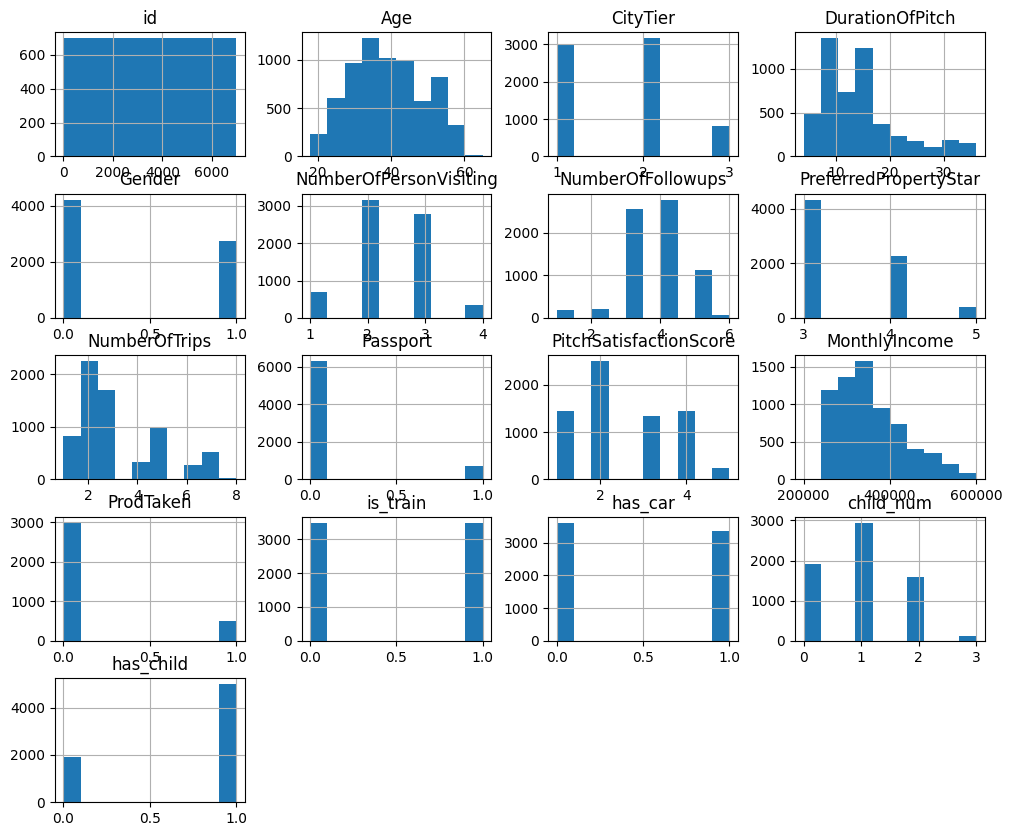

In [ ]:
# prompt: EDAをしたい

# 欠損値の確認
combined_data.isnull().sum()

# ヒストグラムの表示
combined_data.hist(figsize=(12, 10))
plt.show()

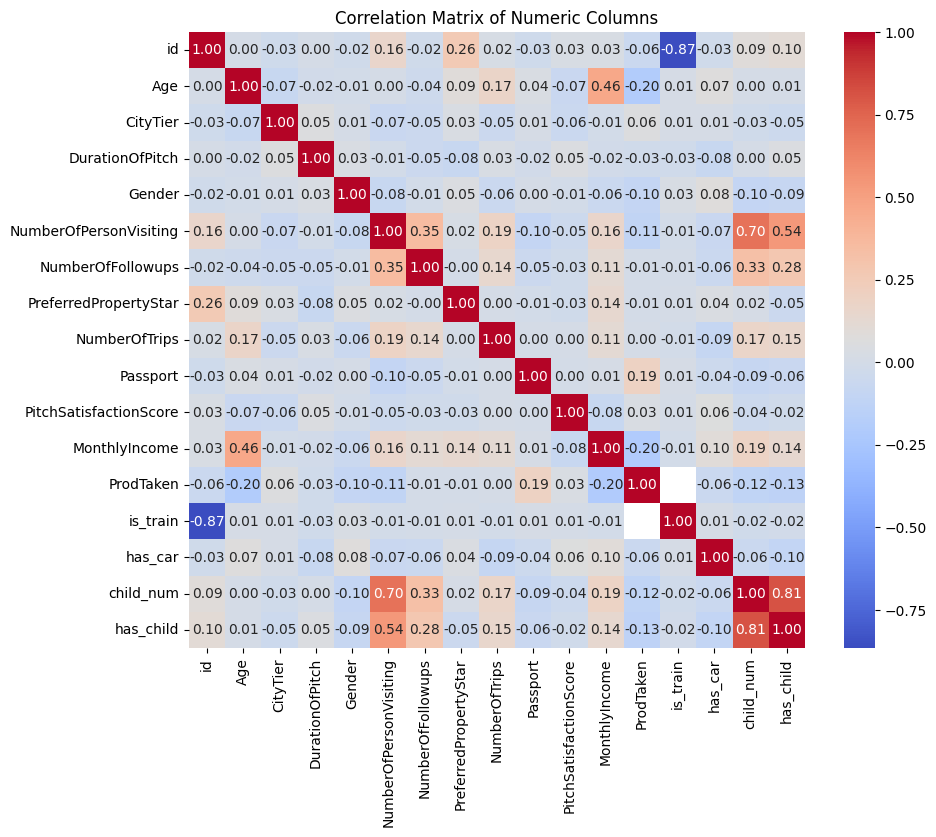

In [ ]:
# 相関行列の表示
# 数値型のカラムに絞って相関行列を計算
numeric_cols = combined_data.select_dtypes(include=['number']).columns
corr_matrix = combined_data[numeric_cols].corr()

# 相関行列をヒートマップで表示
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', square=True)
plt.title('Correlation Matrix of Numeric Columns')
plt.show()

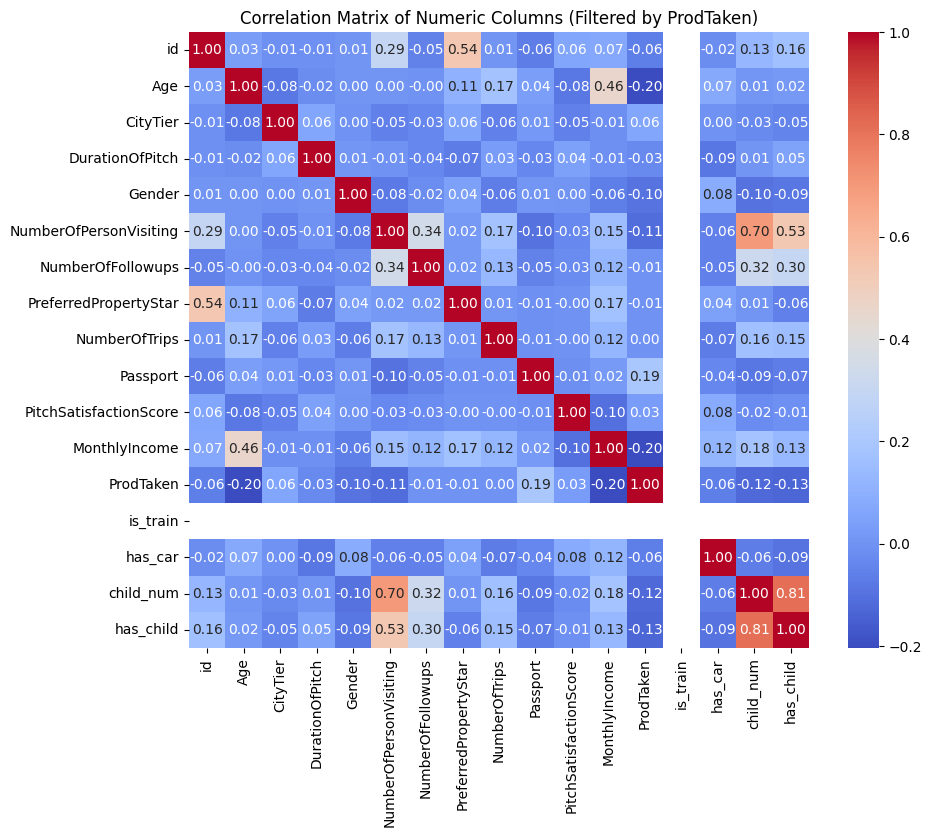

In [ ]:
# 'ProdTaken' が null ではないものに絞り込む
filtered_data = combined_data[combined_data['ProdTaken'].notnull()]

# 数値型のカラムに絞って相関行列を計算
numeric_cols = filtered_data.select_dtypes(include=['number']).columns
corr_matrix = filtered_data[numeric_cols].corr()

# 相関行列をヒートマップで表示
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Numeric Columns (Filtered by ProdTaken)')
plt.show()

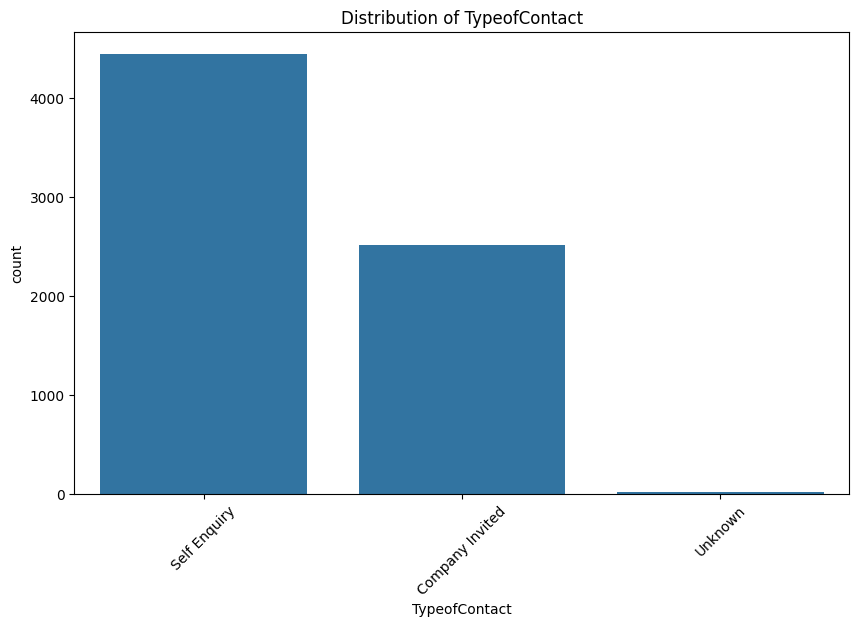

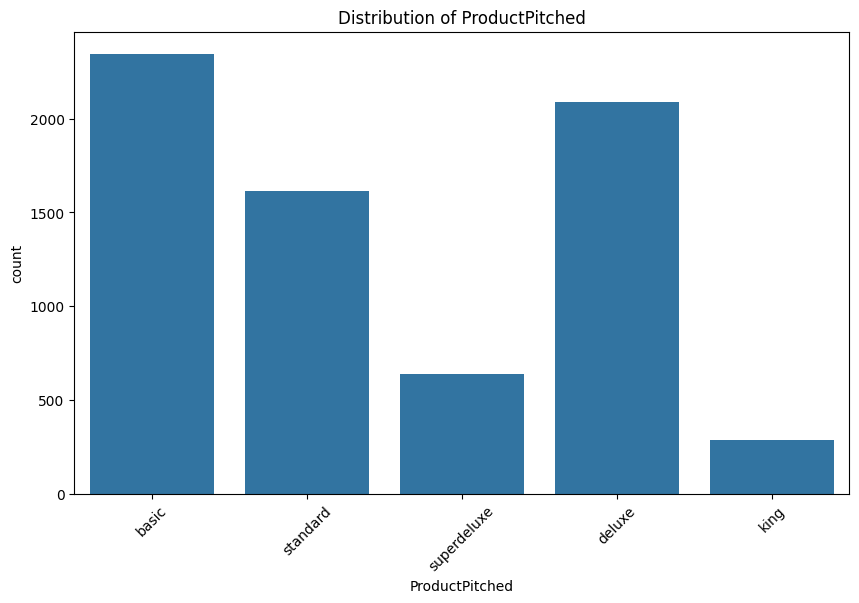

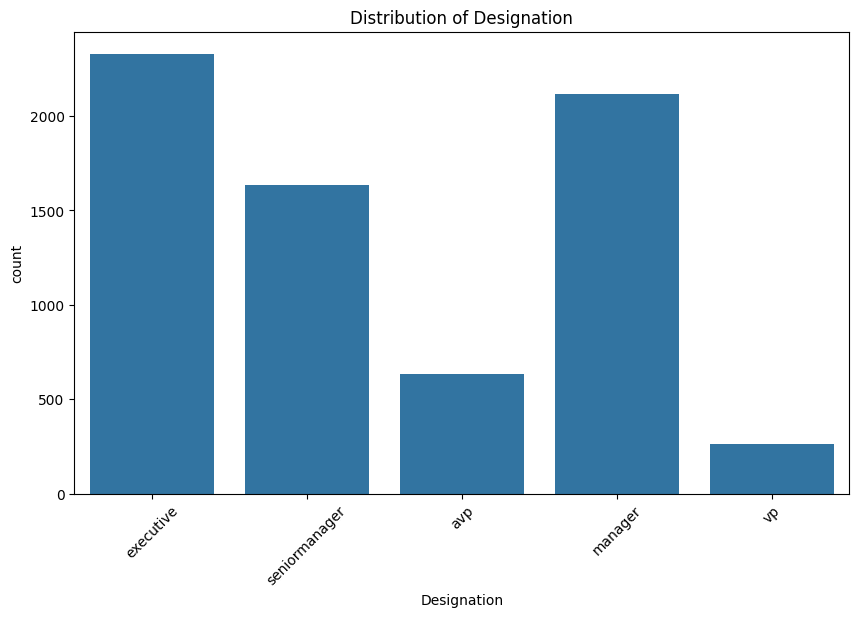

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 20195 (\N{CJK UNIFIED IDEOGRAPH-4EE3}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


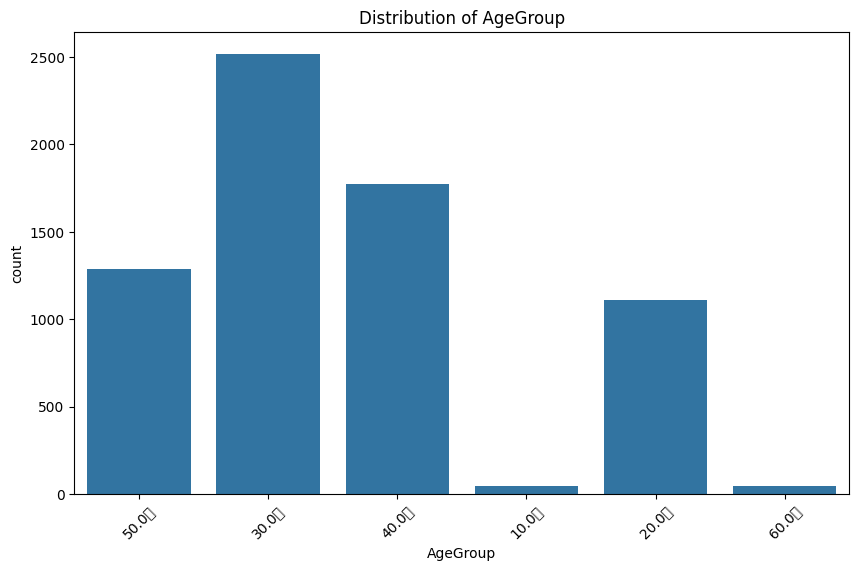

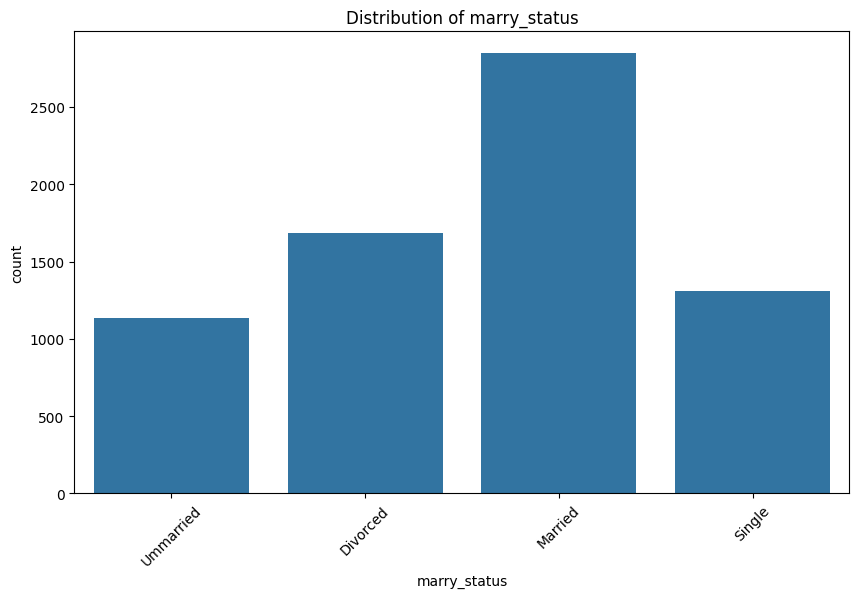

In [ ]:
# カテゴリカル変数の可視化
categorical_cols = ['TypeofContact', 'ProductPitched', 'Designation', 'AgeGroup', 'marry_status']
for col in categorical_cols:
    plt.figure(figsize=(10, 6))
    sns.countplot(x=col, data=combined_data)
    plt.xticks(rotation=45)
    plt.title(f'Distribution of {col}')
    plt.show()

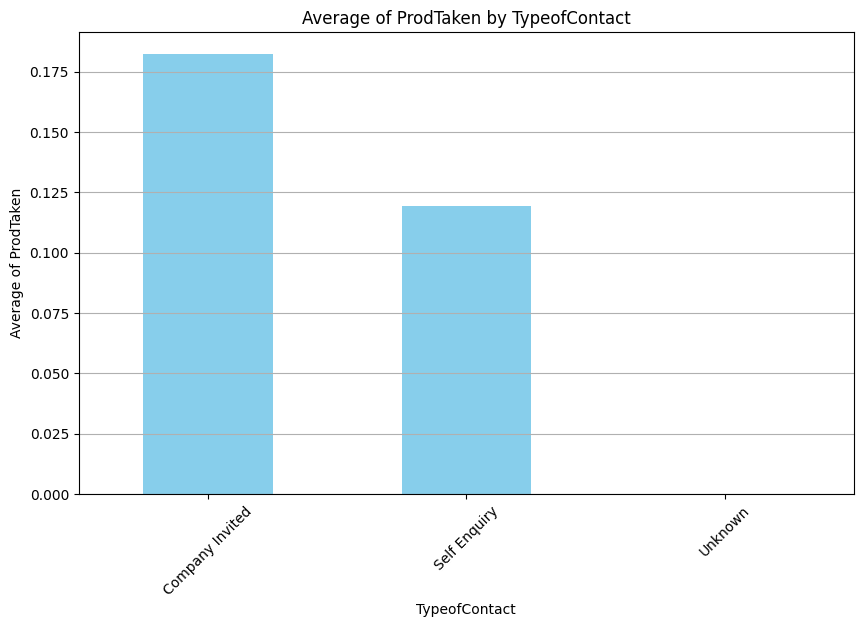

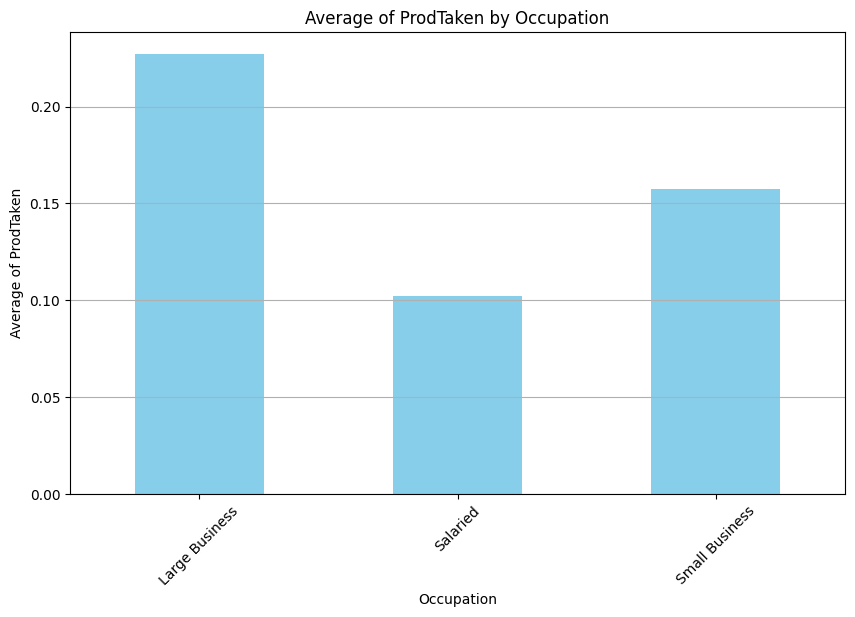

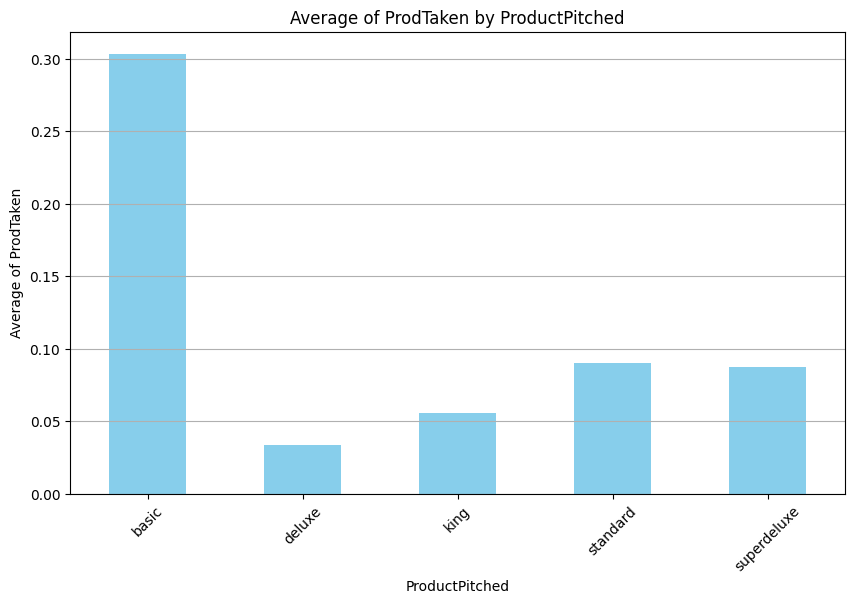

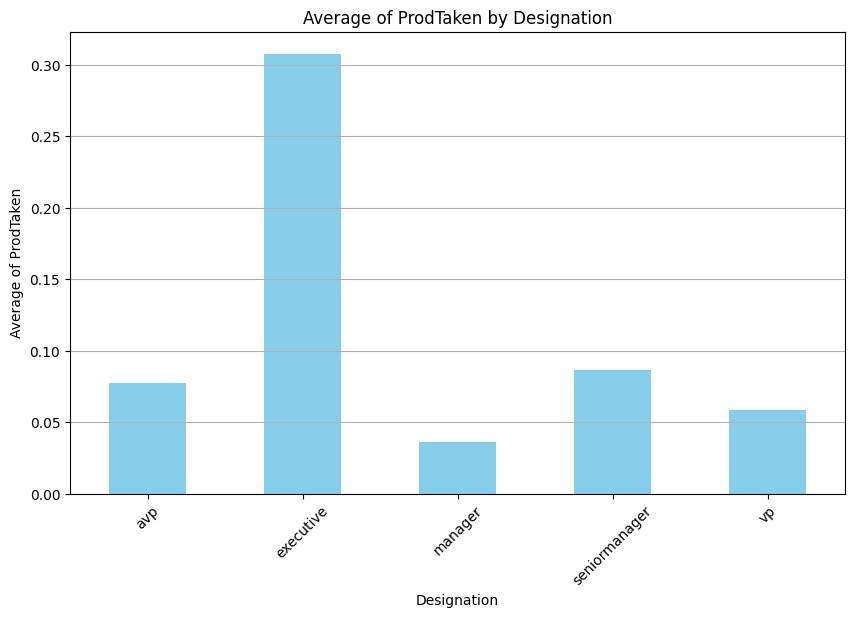

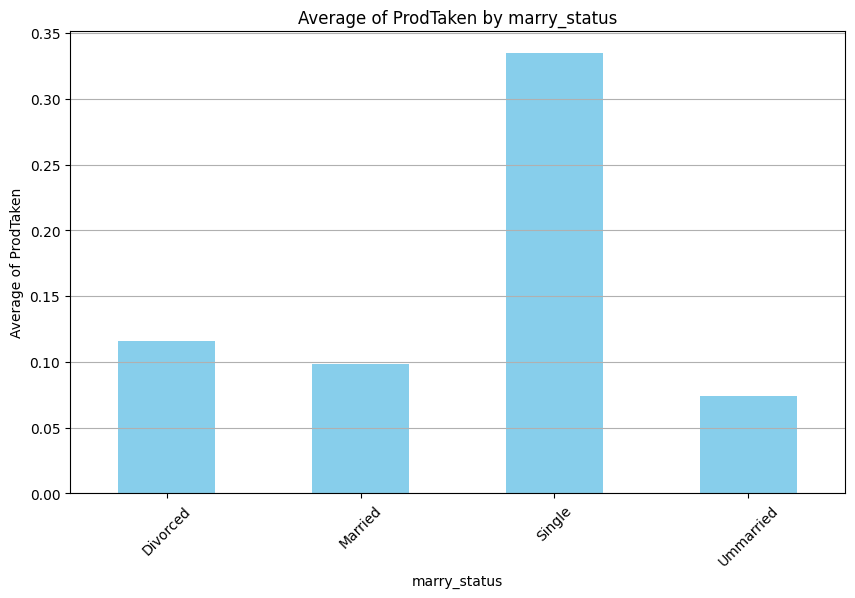

In [ ]:
# カテゴリカル変数のリスト
categorical_cols = ['TypeofContact','Occupation', 'ProductPitched', 'Designation', 'marry_status']

# カテゴリカル変数ごとに 'ProdTaken' の平均を計算し、棒グラフで可視化
for col in categorical_cols:
    plt.figure(figsize=(10, 6))

    # 各カテゴリごとの 'ProdTaken' の平均を計算
    mean_values = combined_data.groupby(col)['ProdTaken'].mean()

    # 棒グラフを描画
    mean_values.plot(kind='bar', color='skyblue')
    plt.title(f'Average of ProdTaken by {col}')
    plt.xlabel(col)
    plt.ylabel('Average of ProdTaken')
    plt.xticks(rotation=45)
    plt.grid(axis='y')

    # グラフを表示
    plt.show()

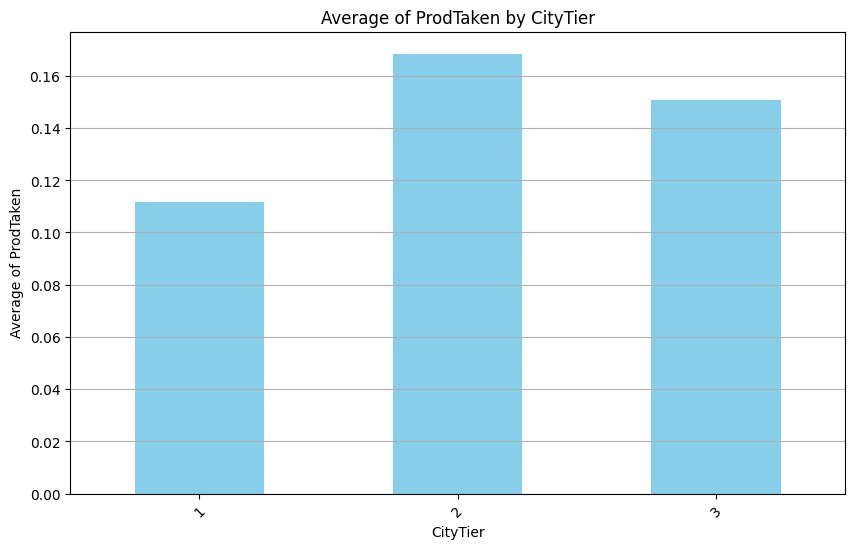

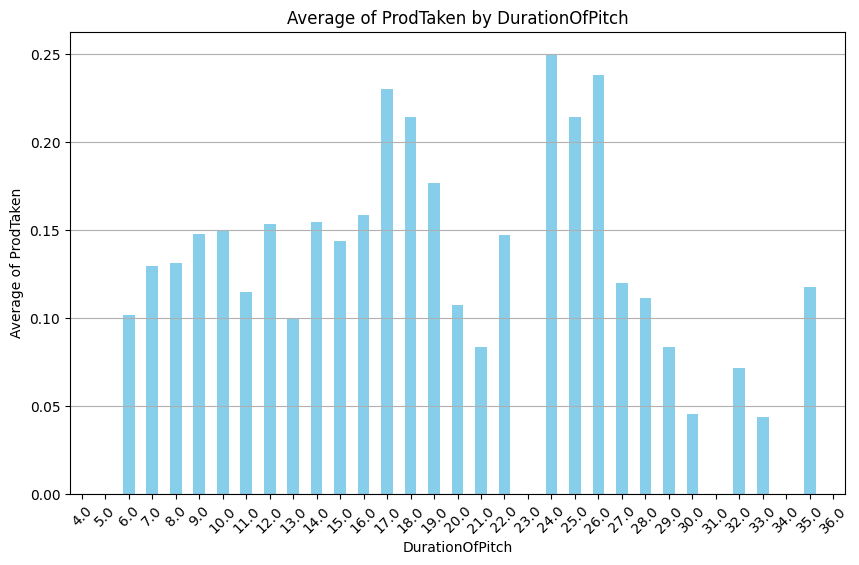

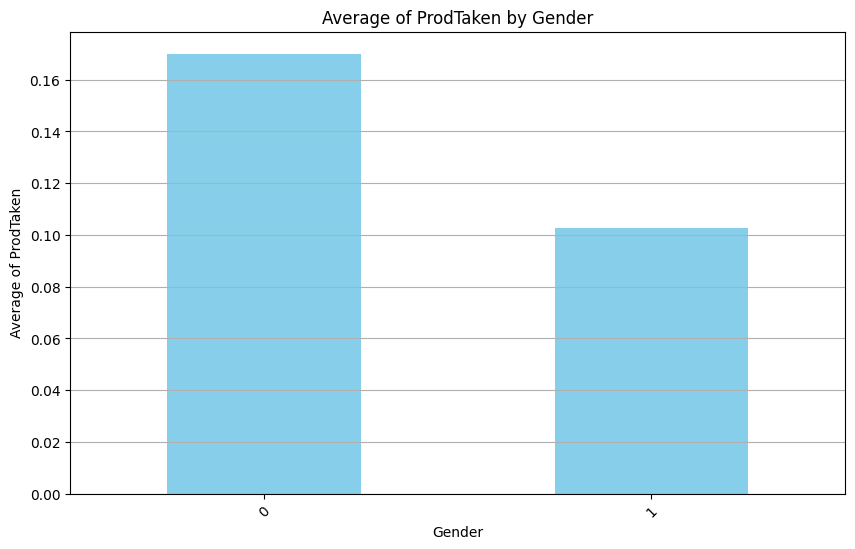

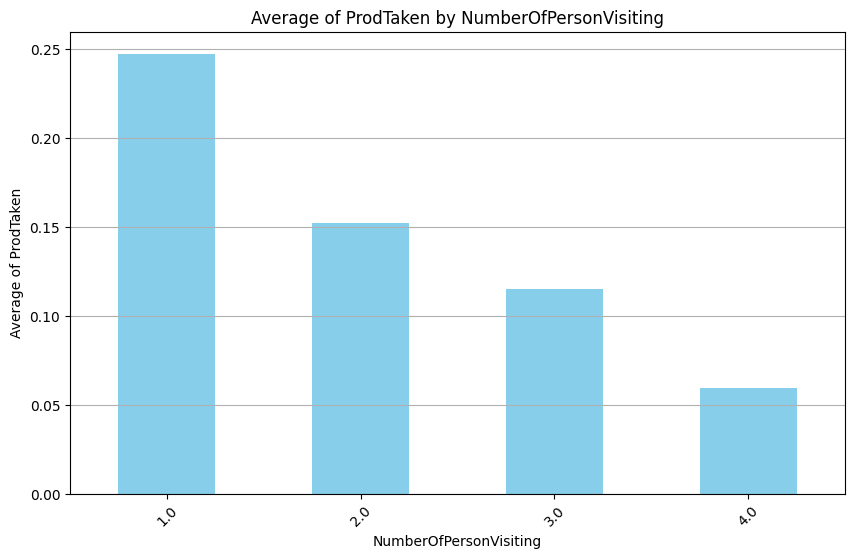

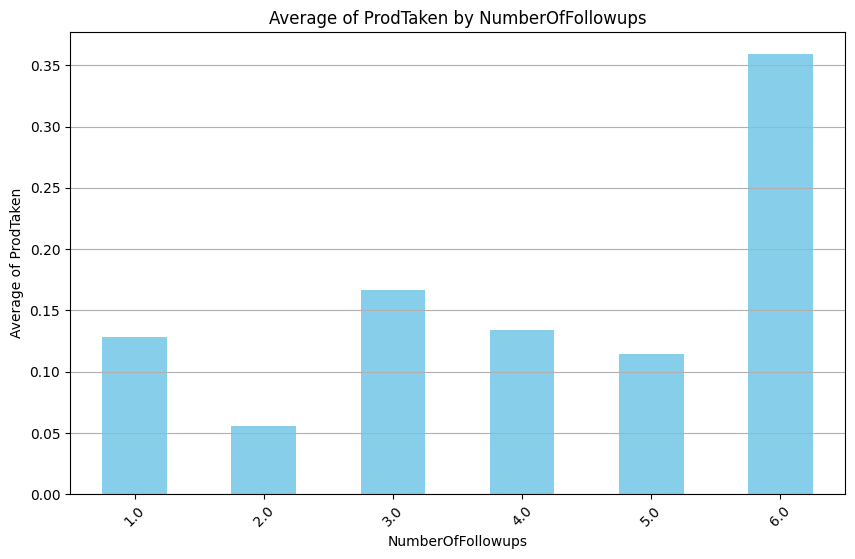

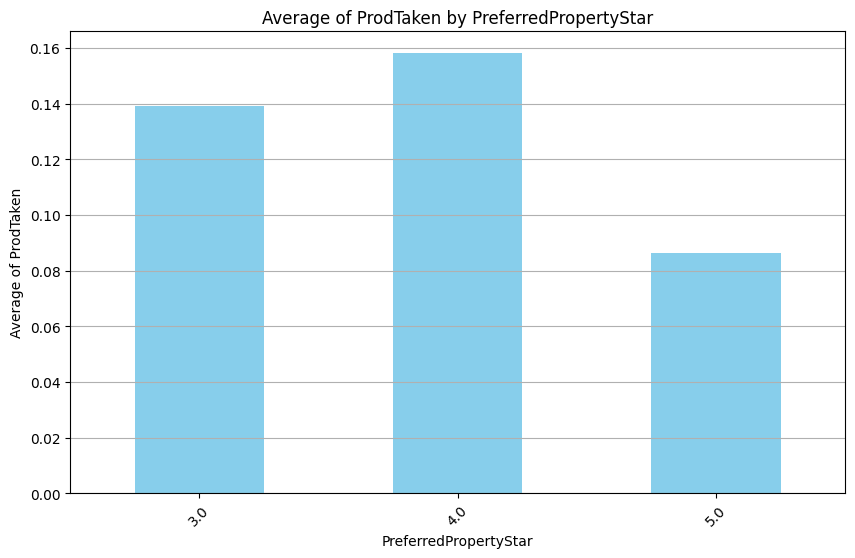

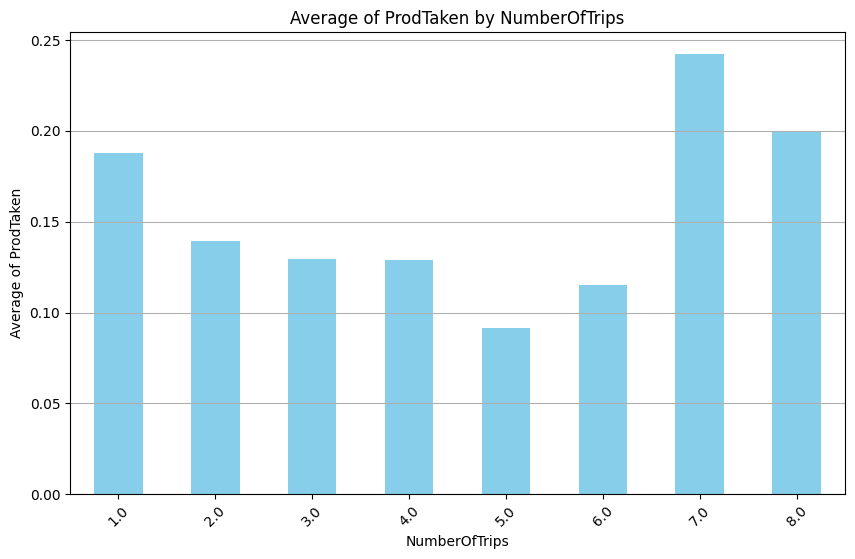

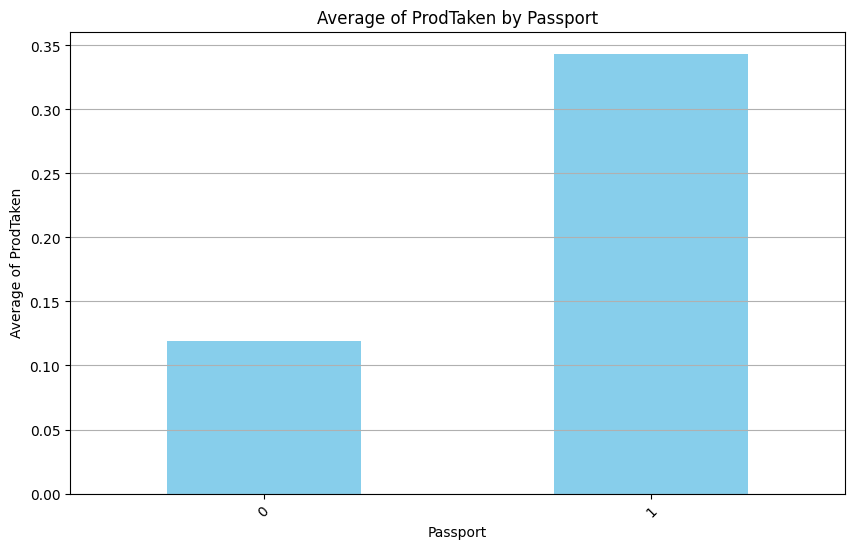

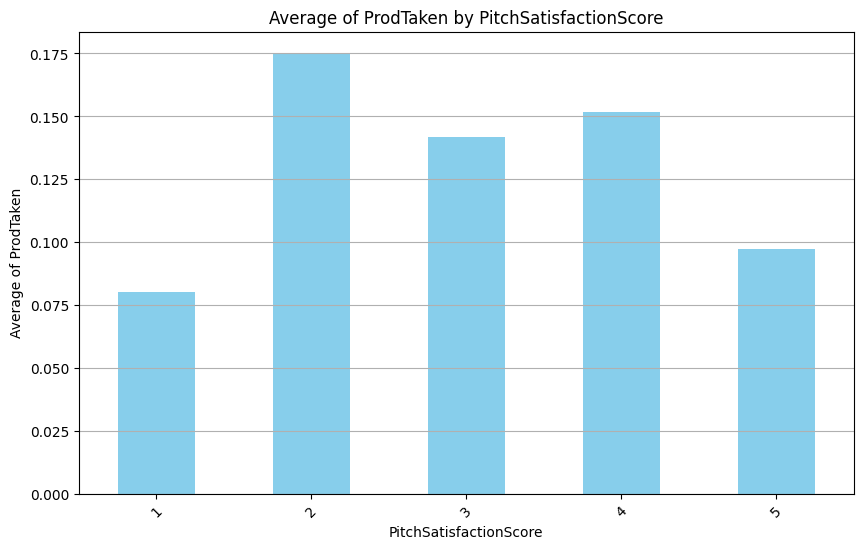

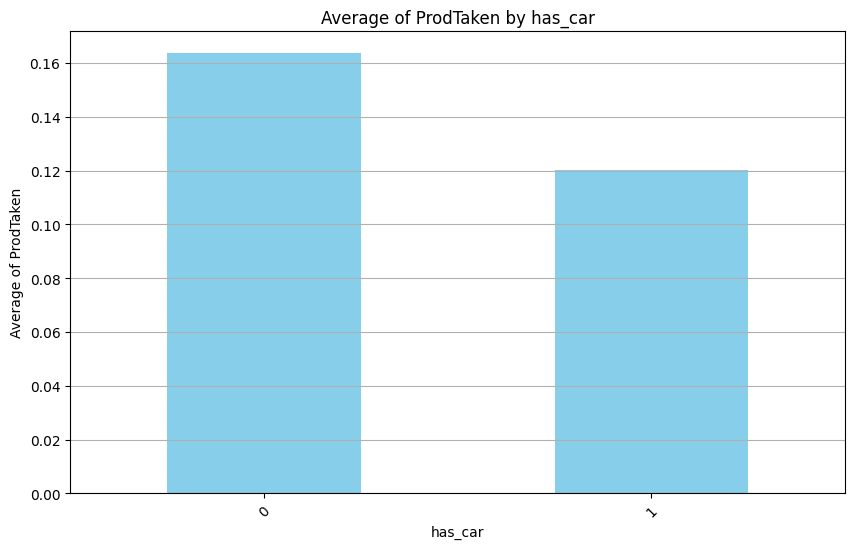

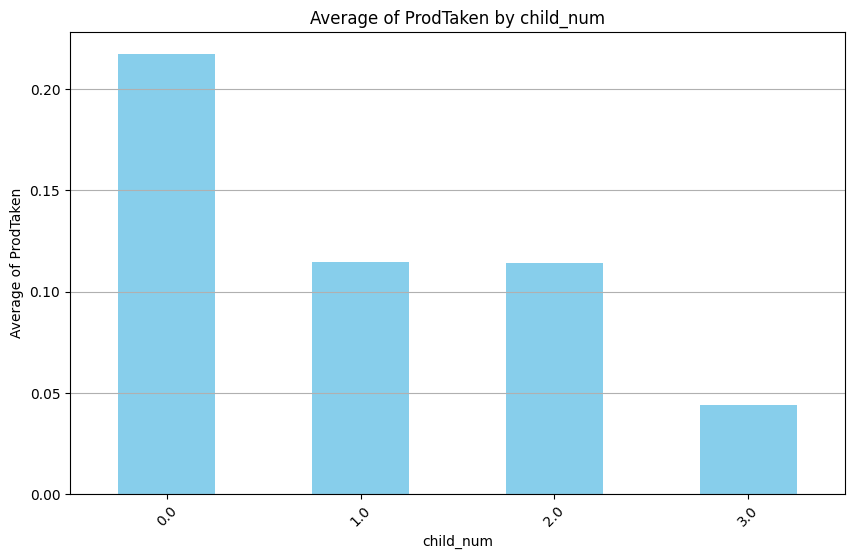

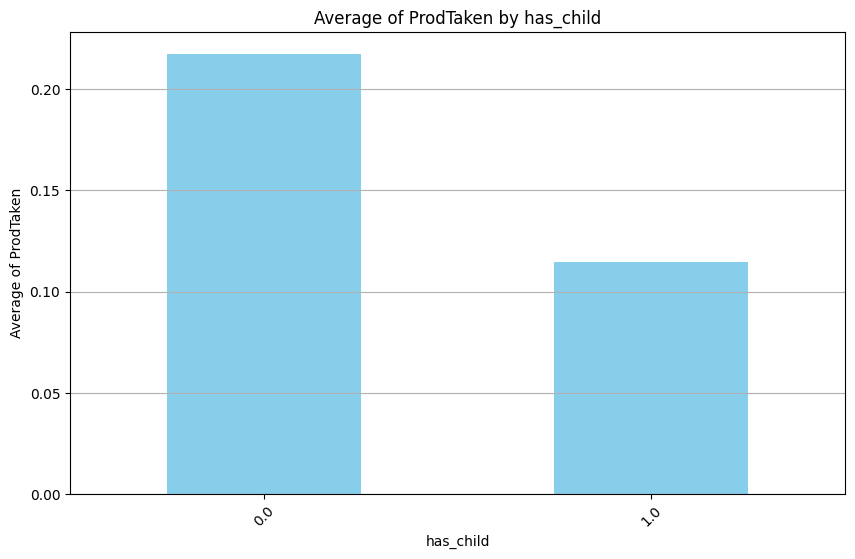

In [ ]:
# 数値変数のリスト
numeric_cols = ['CityTier', 'DurationOfPitch', 'Gender', 'NumberOfPersonVisiting', 'NumberOfFollowups','PreferredPropertyStar','NumberOfTrips','Passport','PitchSatisfactionScore','has_car','child_num','has_child']

# カテゴリカル変数ごとに 'ProdTaken' の平均を計算し、棒グラフで可視化
for col in numeric_cols:
    plt.figure(figsize=(10, 6))

    # 各カテゴリごとの 'ProdTaken' の平均を計算
    mean_values = combined_data.groupby(col)['ProdTaken'].mean()

    # 棒グラフを描画
    mean_values.plot(kind='bar', color='skyblue')
    plt.title(f'Average of ProdTaken by {col}')
    plt.xlabel(col)
    plt.ylabel('Average of ProdTaken')
    plt.xticks(rotation=45)
    plt.grid(axis='y')

    # グラフを表示
    plt.show()

/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 20195 (\N{CJK UNIFIED IDEOGRAPH-4EE3}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 20195 (\N{CJK UNIFIED IDEOGRAPH-4EE3}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


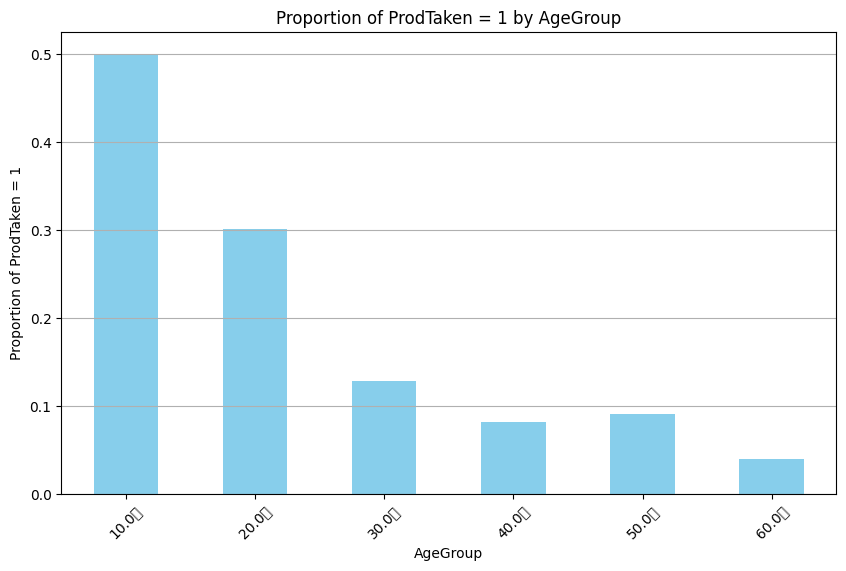

In [ ]:
# 'AgeGroup' ごとに 'ProdTaken' が 1 の割合を計算
prod_taken_by_age_group = filtered_data.groupby('AgeGroup')['ProdTaken'].mean()

# 棒グラフを描画
plt.figure(figsize=(10, 6))
prod_taken_by_age_group.plot(kind='bar', color='skyblue')
plt.title('Proportion of ProdTaken = 1 by AgeGroup')
plt.xlabel('AgeGroup')
plt.ylabel('Proportion of ProdTaken = 1')
plt.xticks(rotation=45)
plt.grid(axis='y')

# グラフを表示

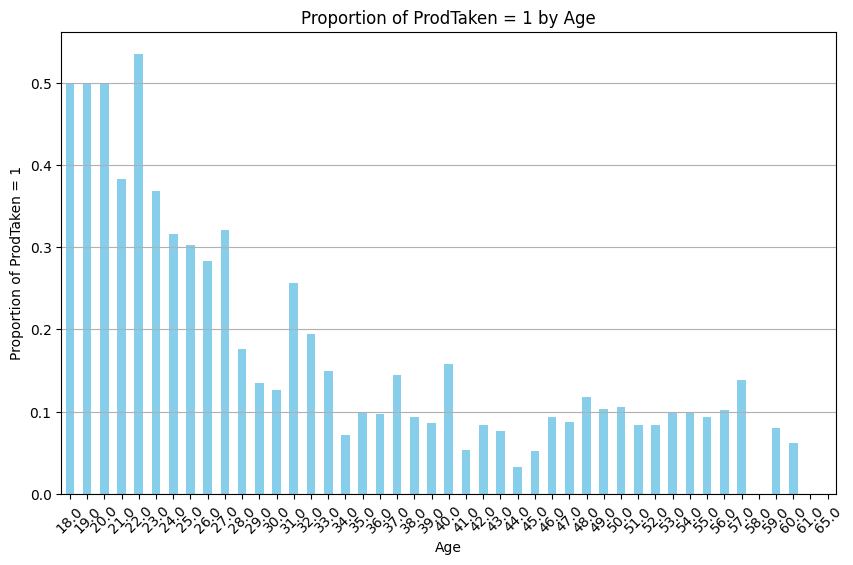

In [ ]:
# 'Age' ごとに 'ProdTaken' が 1 の割合を計算
prod_taken_by_age = filtered_data.groupby('Age')['ProdTaken'].mean()

# 棒グラフを描画
plt.figure(figsize=(10, 6))
prod_taken_by_age.plot(kind='bar', color='skyblue')
plt.title('Proportion of ProdTaken = 1 by Age')
plt.xlabel('Age')
plt.ylabel('Proportion of ProdTaken = 1')
plt.xticks(rotation=45)
plt.grid(axis='y')

# グラフを表示

<ipython-input-408-94c9d4409a29>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['MonthlyIncome'] = pd.to_numeric(filtered_data['MonthlyIncome'], errors='coerce')
<ipython-input-408-94c9d4409a29>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data_non_nan['IncomeGroup'] = pd.cut(filtered_data_non_nan['MonthlyIncome'], bins=10)
<ipython-input-408-94c9d4409a29>:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. P

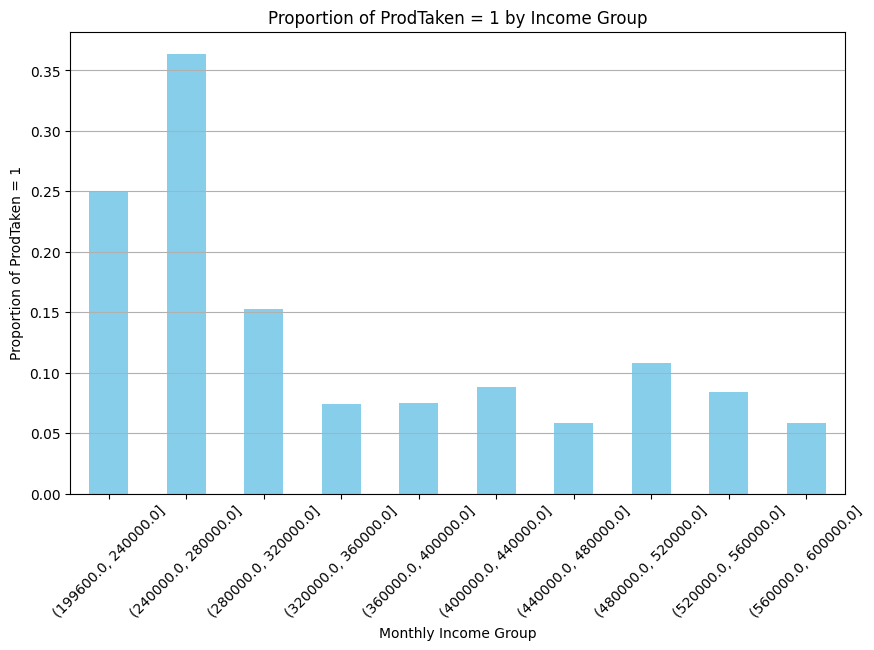

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# 'MonthlyIncome' を 10 分割してビンに分ける
# 'MonthlyIncome' を数値型に変換（必要な場合）
filtered_data['MonthlyIncome'] = pd.to_numeric(filtered_data['MonthlyIncome'], errors='coerce')

# 'MonthlyIncome' が NaN ではないデータに対してビンに分割
filtered_data_non_nan = filtered_data.dropna(subset=['MonthlyIncome'])

# 'MonthlyIncome' を 10 分割してビンに分ける
filtered_data_non_nan['IncomeGroup'] = pd.cut(filtered_data_non_nan['MonthlyIncome'], bins=10)

# 'IncomeGroup' ごとに 'ProdTaken' が 1 の割合を計算
prod_taken_by_income_group = filtered_data_non_nan.groupby('IncomeGroup')['ProdTaken'].mean()

# 棒グラフを描画
plt.figure(figsize=(10, 6))
prod_taken_by_income_group.plot(kind='bar', color='skyblue')
plt.title('Proportion of ProdTaken = 1 by Income Group')
plt.xlabel('Monthly Income Group')
plt.ylabel('Proportion of ProdTaken = 1')
plt.xticks(rotation=45)
plt.grid(axis='y')

# グラフを表示
plt.show()

<ipython-input-409-8776f92a5fa9>:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_data = filtered_data_non_nan.groupby(['IncomeGroup', 'AgeGroup'])['ProdTaken'].mean().unstack()
/usr/local/lib/python3.10/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 20195 (\N{CJK UNIFIED IDEOGRAPH-4EE3}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 20195 (\N{CJK UNIFIED IDEOGRAPH-4EE3}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


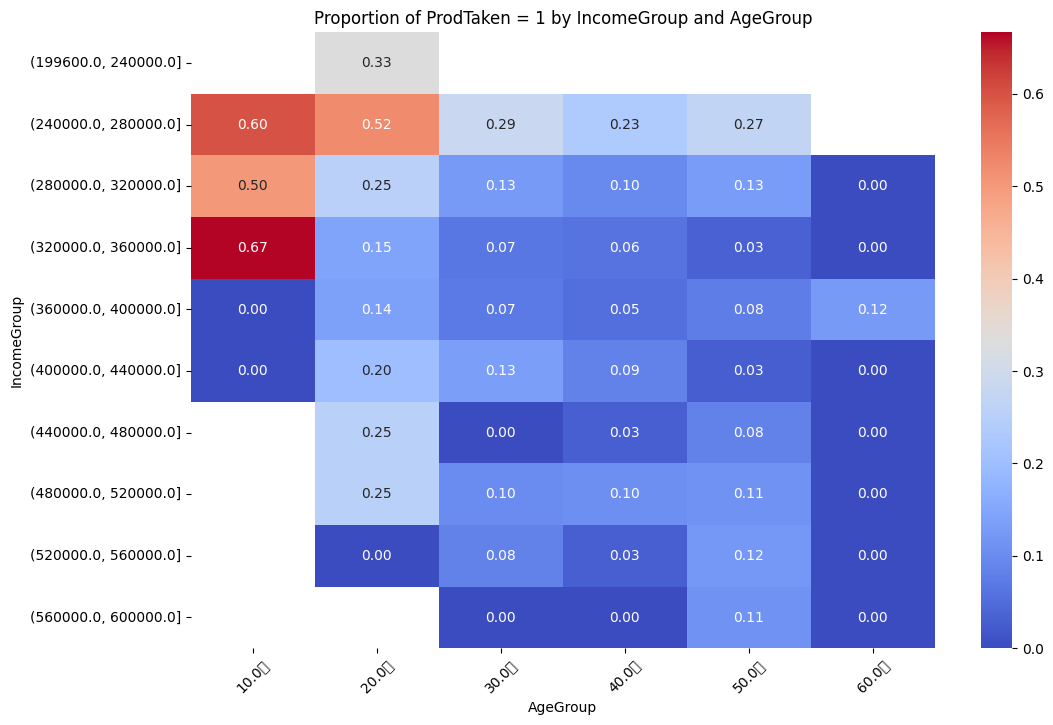

In [ ]:
# 'IncomeGroup' と 'AgeGroup' でグループ化し、 'ProdTaken' の平均を計算
grouped_data = filtered_data_non_nan.groupby(['IncomeGroup', 'AgeGroup'])['ProdTaken'].mean().unstack()

# ヒートマップを描画
plt.figure(figsize=(12, 8))
sns.heatmap(grouped_data, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('Proportion of ProdTaken = 1 by IncomeGroup and AgeGroup')
plt.xlabel('AgeGroup')
plt.ylabel('IncomeGroup')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()

<ipython-input-410-044bfd2929c7>:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_data = filtered_data_non_nan.groupby(['IncomeGroup', 'NumberOfPersonVisiting'])['ProdTaken'].mean().unstack()


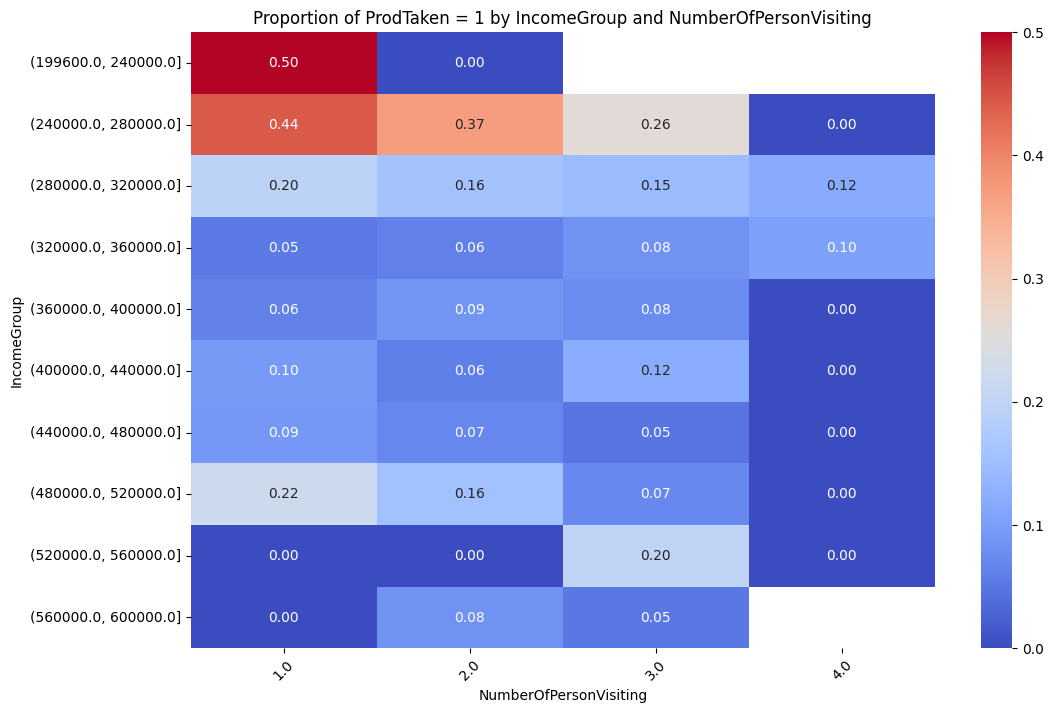

In [ ]:
# 'IncomeGroup' と 'AgeGroup' でグループ化し、 'ProdTaken' の平均を計算
grouped_data = filtered_data_non_nan.groupby(['IncomeGroup', 'NumberOfPersonVisiting'])['ProdTaken'].mean().unstack()

# ヒートマップを描画
plt.figure(figsize=(12, 8))
sns.heatmap(grouped_data, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('Proportion of ProdTaken = 1 by IncomeGroup and NumberOfPersonVisiting')
plt.xlabel('NumberOfPersonVisiting')
plt.ylabel('IncomeGroup')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()

/usr/local/lib/python3.10/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 20195 (\N{CJK UNIFIED IDEOGRAPH-4EE3}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 20195 (\N{CJK UNIFIED IDEOGRAPH-4EE3}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


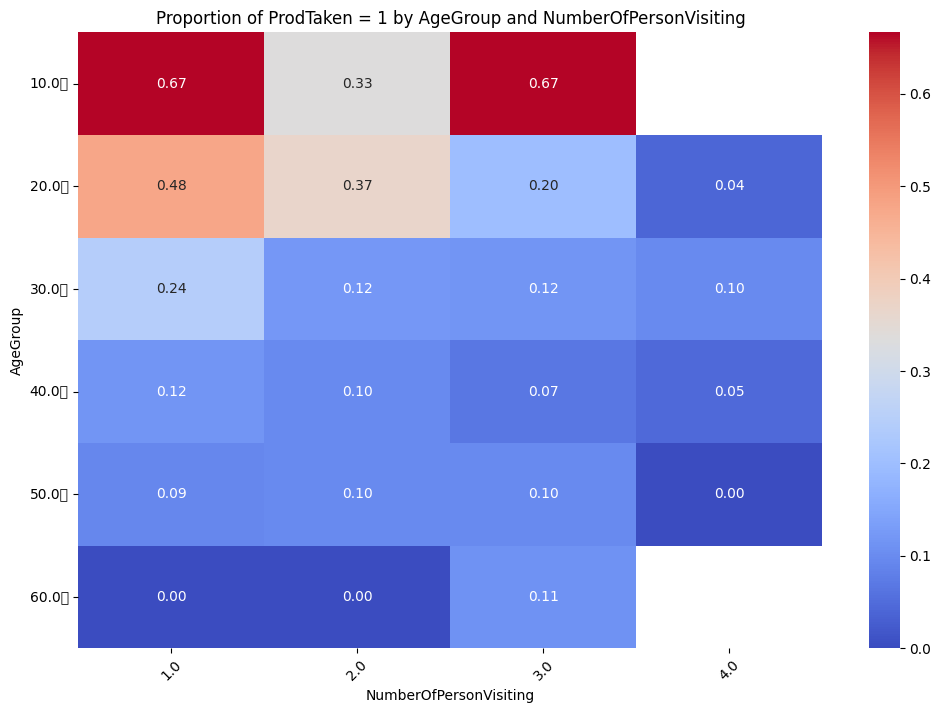

In [ ]:
# 'IncomeGroup' と 'AgeGroup' でグループ化し、 'ProdTaken' の平均を計算
grouped_data = filtered_data_non_nan.groupby(['AgeGroup', 'NumberOfPersonVisiting'])['ProdTaken'].mean().unstack()

# ヒートマップを描画
plt.figure(figsize=(12, 8))
sns.heatmap(grouped_data, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('Proportion of ProdTaken = 1 by AgeGroup and NumberOfPersonVisiting')
plt.xlabel('NumberOfPersonVisiting')
plt.ylabel('AgeGroup')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()

<ipython-input-412-8a11da961cd2>:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_data = filtered_data_non_nan.groupby(['IncomeGroup', 'DurationOfPitch'])['ProdTaken'].mean().unstack()


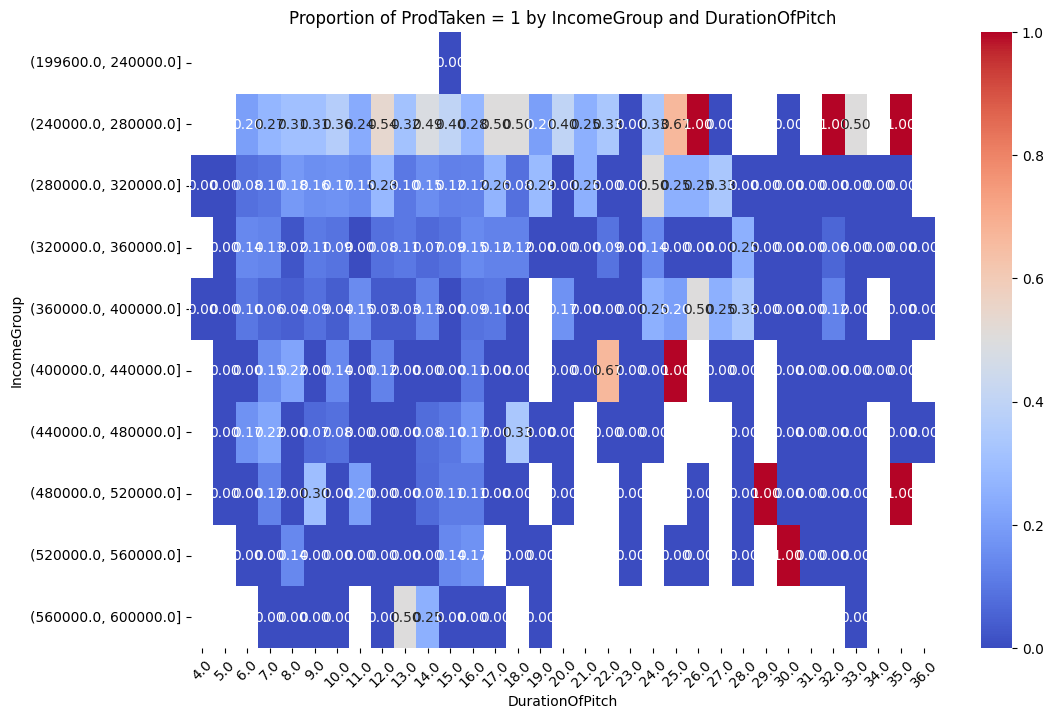

In [ ]:
# 'IncomeGroup' と 'AgeGroup' でグループ化し、 'ProdTaken' の平均を計算
grouped_data = filtered_data_non_nan.groupby(['IncomeGroup', 'DurationOfPitch'])['ProdTaken'].mean().unstack()

# ヒートマップを描画
plt.figure(figsize=(12, 8))
sns.heatmap(grouped_data, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('Proportion of ProdTaken = 1 by IncomeGroup and DurationOfPitch')
plt.xlabel('DurationOfPitch')
plt.ylabel('IncomeGroup')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()

<ipython-input-413-41257b7e92b0>:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_data = filtered_data_non_nan.groupby(['IncomeGroup', 'NumberOfTrips'])['ProdTaken'].mean().unstack()


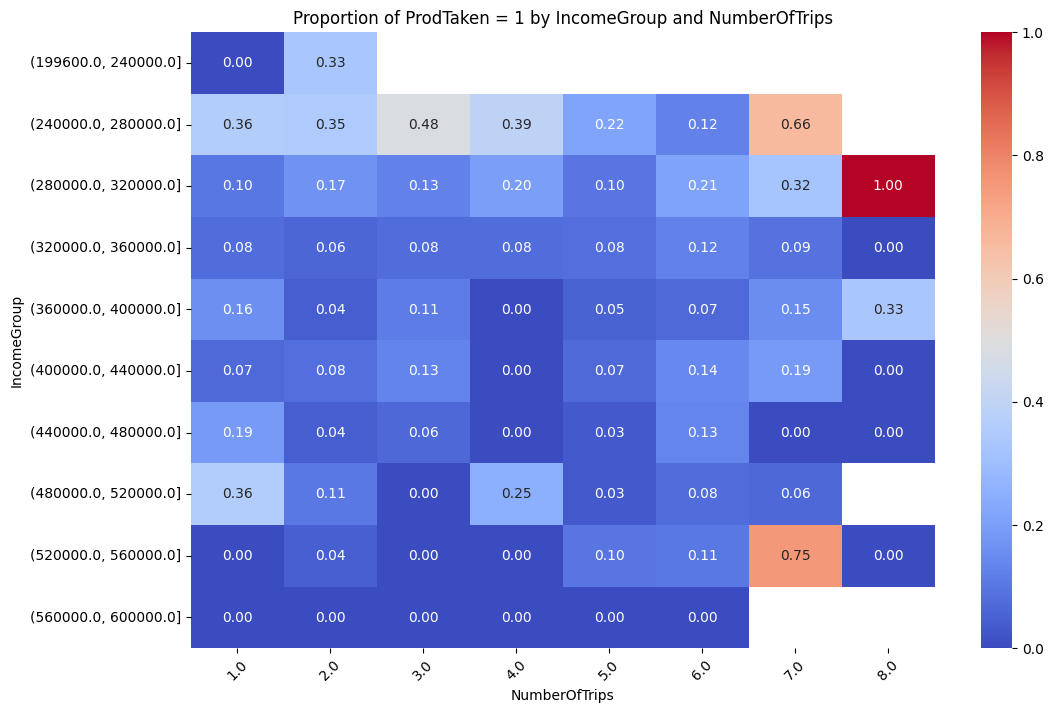

In [ ]:
# 'IncomeGroup' と 'AgeGroup' でグループ化し、 'ProdTaken' の平均を計算
grouped_data = filtered_data_non_nan.groupby(['IncomeGroup', 'NumberOfTrips'])['ProdTaken'].mean().unstack()

# ヒートマップを描画
plt.figure(figsize=(12, 8))
sns.heatmap(grouped_data, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('Proportion of ProdTaken = 1 by IncomeGroup and NumberOfTrips')
plt.xlabel('NumberOfTrips')
plt.ylabel('IncomeGroup')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()

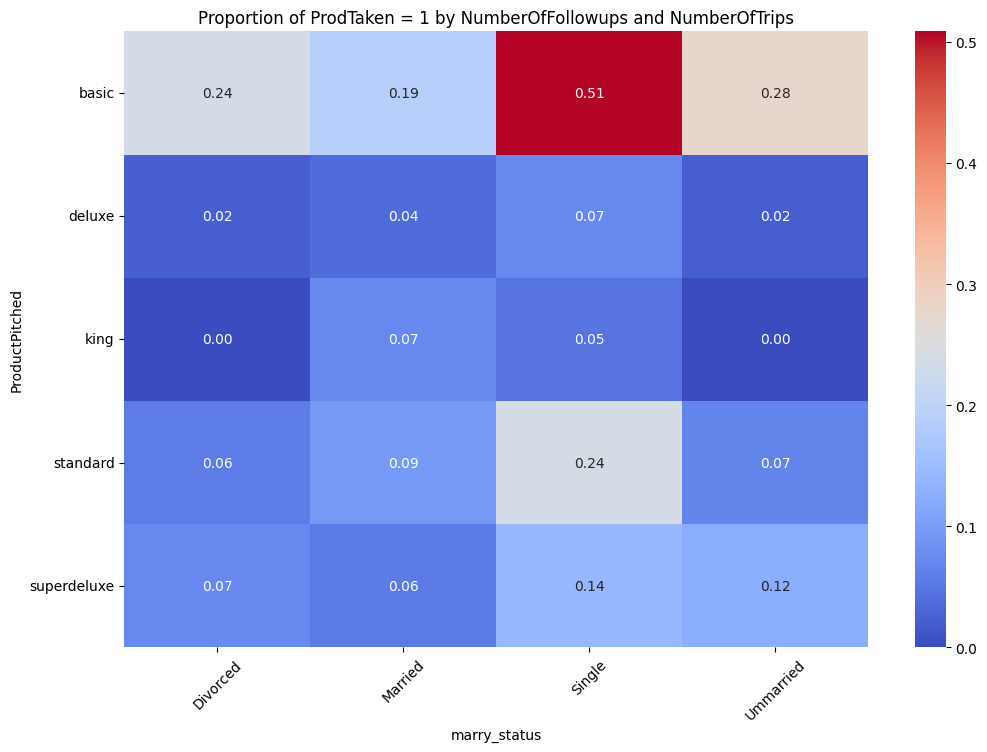

In [ ]:
# 'IncomeGroup' と 'AgeGroup' でグループ化し、 'ProdTaken' の平均を計算
grouped_data = filtered_data_non_nan.groupby(['ProductPitched', 'marry_status'])['ProdTaken'].mean().unstack()

# ヒートマップを描画
plt.figure(figsize=(12, 8))
sns.heatmap(grouped_data, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('Proportion of ProdTaken = 1 by NumberOfFollowups and NumberOfTrips')
plt.xlabel('marry_status')
plt.ylabel('ProductPitched')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()

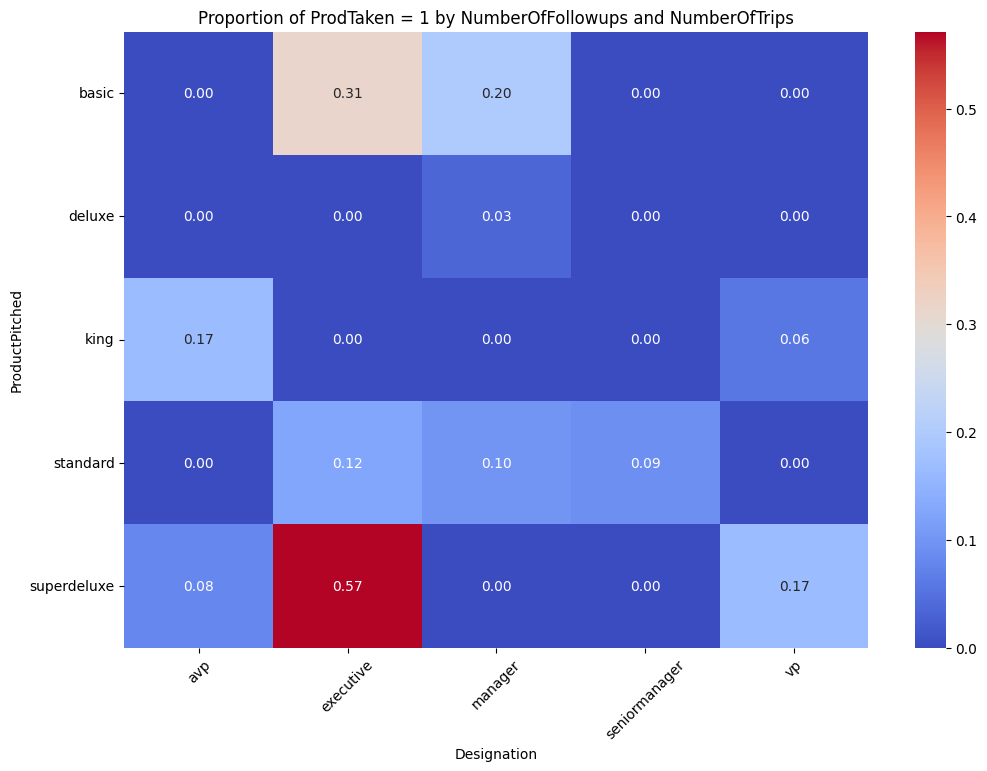

In [ ]:
# 'IncomeGroup' と 'AgeGroup' でグループ化し、 'ProdTaken' の平均を計算
grouped_data = filtered_data_non_nan.groupby(['ProductPitched', 'Designation'])['ProdTaken'].mean().unstack()

# ヒートマップを描画
plt.figure(figsize=(12, 8))
sns.heatmap(grouped_data, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('Proportion of ProdTaken = 1 by NumberOfFollowups and NumberOfTrips')
plt.xlabel('Designation')
plt.ylabel('ProductPitched')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()

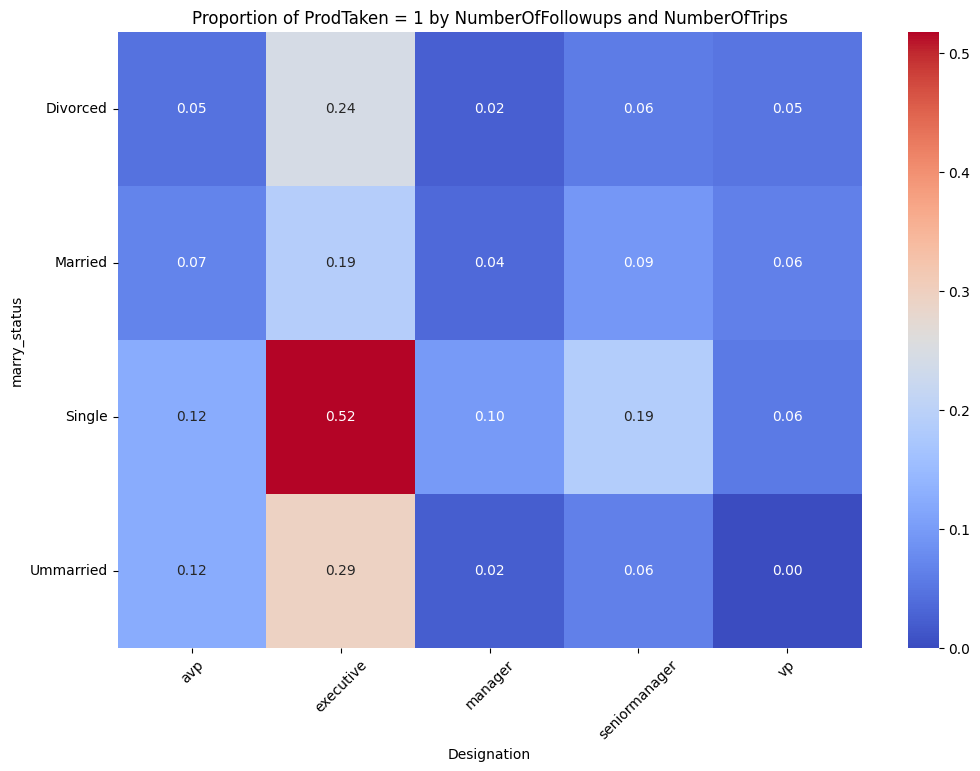

In [ ]:
# 'IncomeGroup' と 'AgeGroup' でグループ化し、 'ProdTaken' の平均を計算
grouped_data = filtered_data_non_nan.groupby(['marry_status', 'Designation'])['ProdTaken'].mean().unstack()

# ヒートマップを描画
plt.figure(figsize=(12, 8))
sns.heatmap(grouped_data, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('Proportion of ProdTaken = 1 by NumberOfFollowups and NumberOfTrips')
plt.xlabel('Designation')
plt.ylabel('marry_status')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()

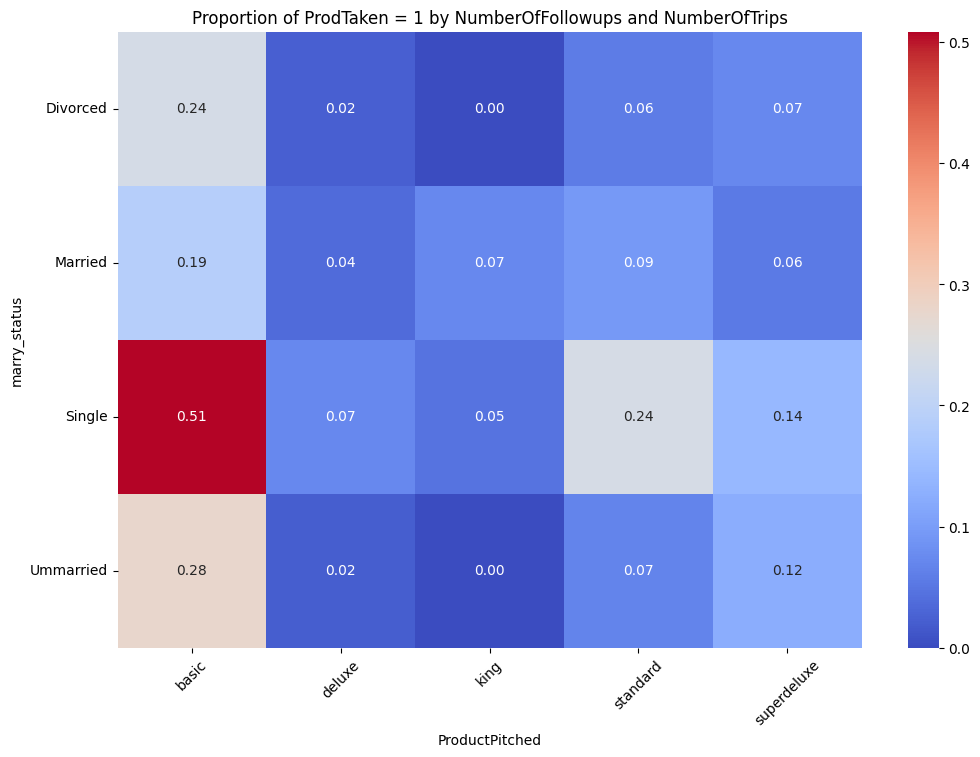

In [ ]:
# 'IncomeGroup' と 'AgeGroup' でグループ化し、 'ProdTaken' の平均を計算
grouped_data = filtered_data_non_nan.groupby(['marry_status', 'ProductPitched'])['ProdTaken'].mean().unstack()

# ヒートマップを描画
plt.figure(figsize=(12, 8))
sns.heatmap(grouped_data, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('Proportion of ProdTaken = 1 by NumberOfFollowups and NumberOfTrips')
plt.xlabel('ProductPitched')
plt.ylabel('marry_status')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()

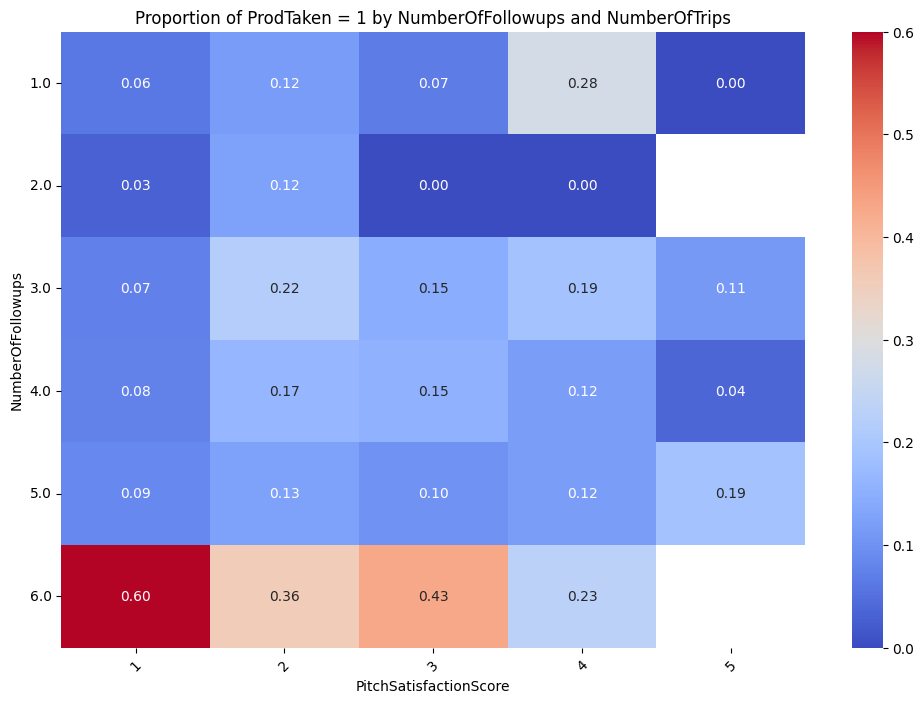

In [ ]:
# 'IncomeGroup' と 'AgeGroup' でグループ化し、 'ProdTaken' の平均を計算
grouped_data = filtered_data_non_nan.groupby(['NumberOfFollowups', 'PitchSatisfactionScore'])['ProdTaken'].mean().unstack()

# ヒートマップを描画
plt.figure(figsize=(12, 8))
sns.heatmap(grouped_data, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('Proportion of ProdTaken = 1 by NumberOfFollowups and NumberOfTrips')
plt.xlabel('PitchSatisfactionScore')
plt.ylabel('NumberOfFollowups')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()

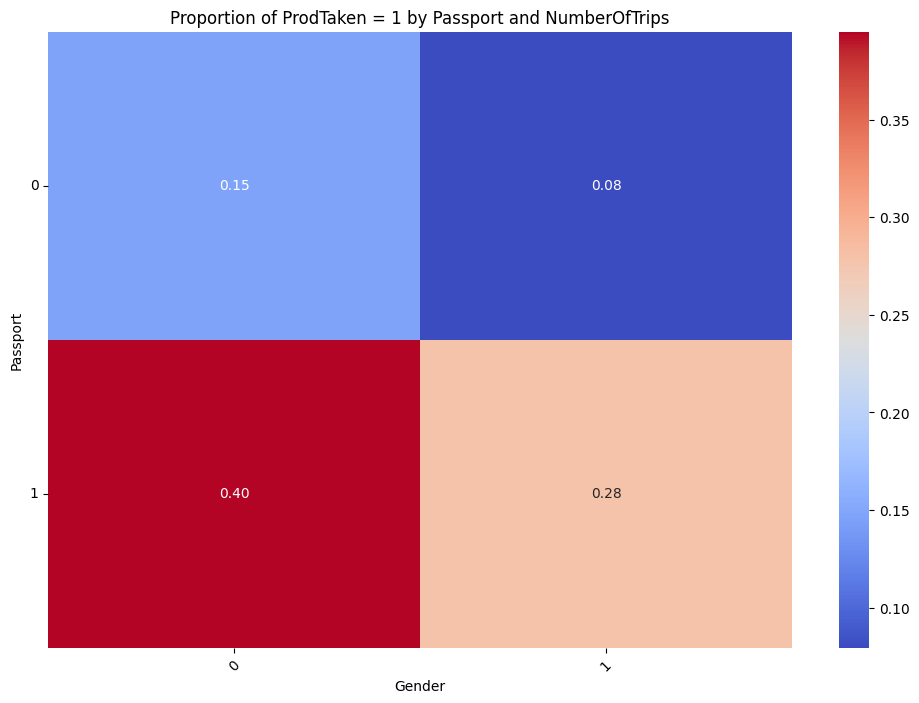

In [ ]:
# 'IncomeGroup' と 'AgeGroup' でグループ化し、 'ProdTaken' の平均を計算
grouped_data = filtered_data_non_nan.groupby(['Passport', 'Gender'])['ProdTaken'].mean().unstack()

# ヒートマップを描画
plt.figure(figsize=(12, 8))
sns.heatmap(grouped_data, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('Proportion of ProdTaken = 1 by Passport and NumberOfTrips')
plt.xlabel('Gender')
plt.ylabel('Passport')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()

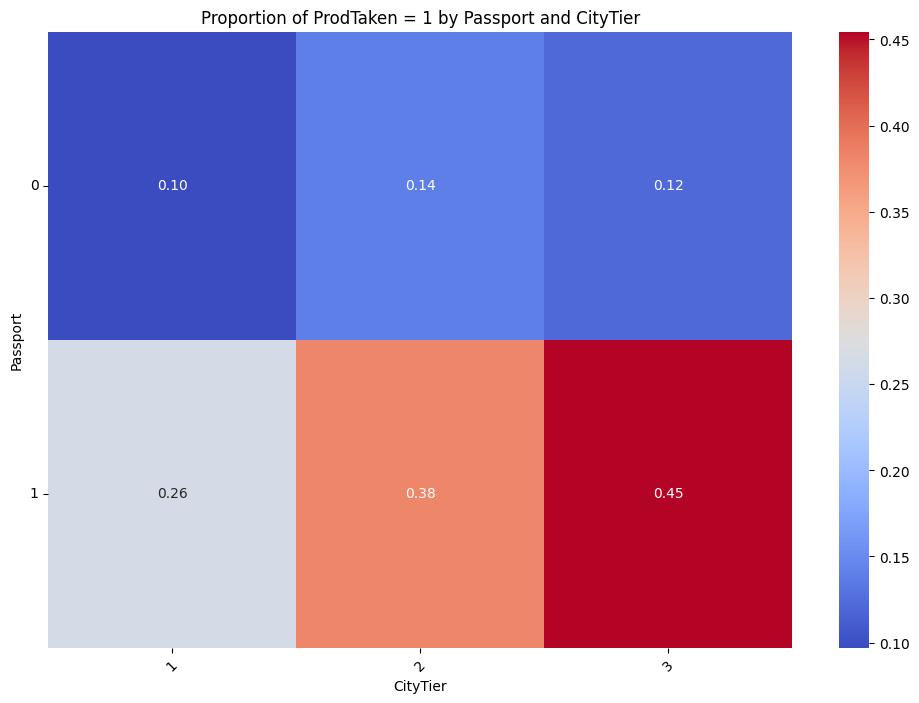

In [ ]:
# 'IncomeGroup' と 'AgeGroup' でグループ化し、 'ProdTaken' の平均を計算
grouped_data = filtered_data_non_nan.groupby(['Passport', 'CityTier'])['ProdTaken'].mean().unstack()

# ヒートマップを描画
plt.figure(figsize=(12, 8))
sns.heatmap(grouped_data, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('Proportion of ProdTaken = 1 by Passport and CityTier')
plt.xlabel('CityTier')
plt.ylabel('Passport')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()

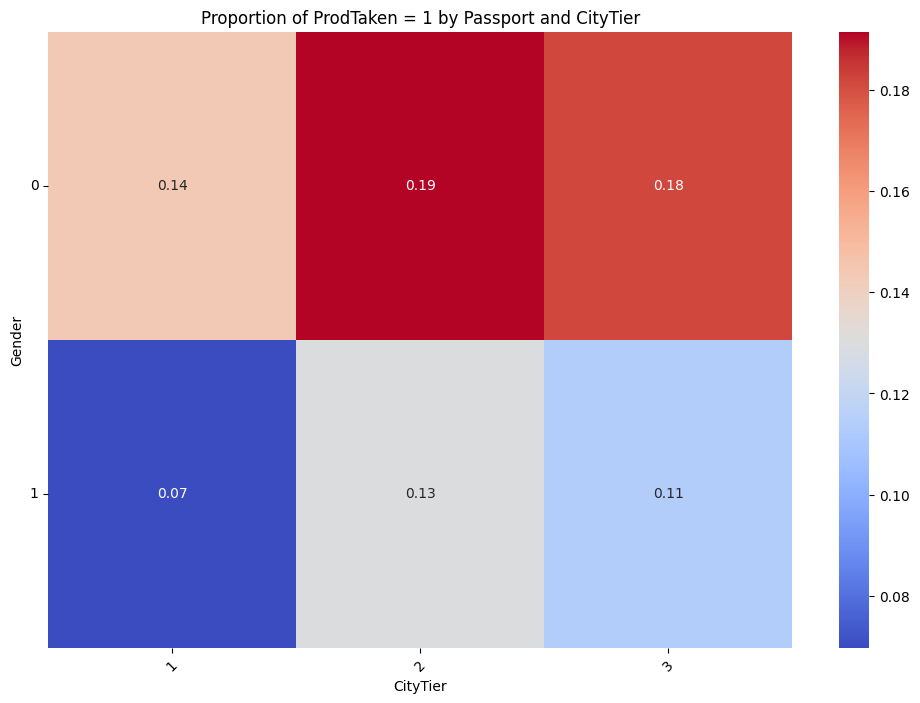

In [ ]:
# 'IncomeGroup' と 'AgeGroup' でグループ化し、 'ProdTaken' の平均を計算
grouped_data = filtered_data_non_nan.groupby(['Gender', 'CityTier'])['ProdTaken'].mean().unstack()

# ヒートマップを描画
plt.figure(figsize=(12, 8))
sns.heatmap(grouped_data, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('Proportion of ProdTaken = 1 by Passport and CityTier')
plt.xlabel('CityTier')
plt.ylabel('Gender')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()

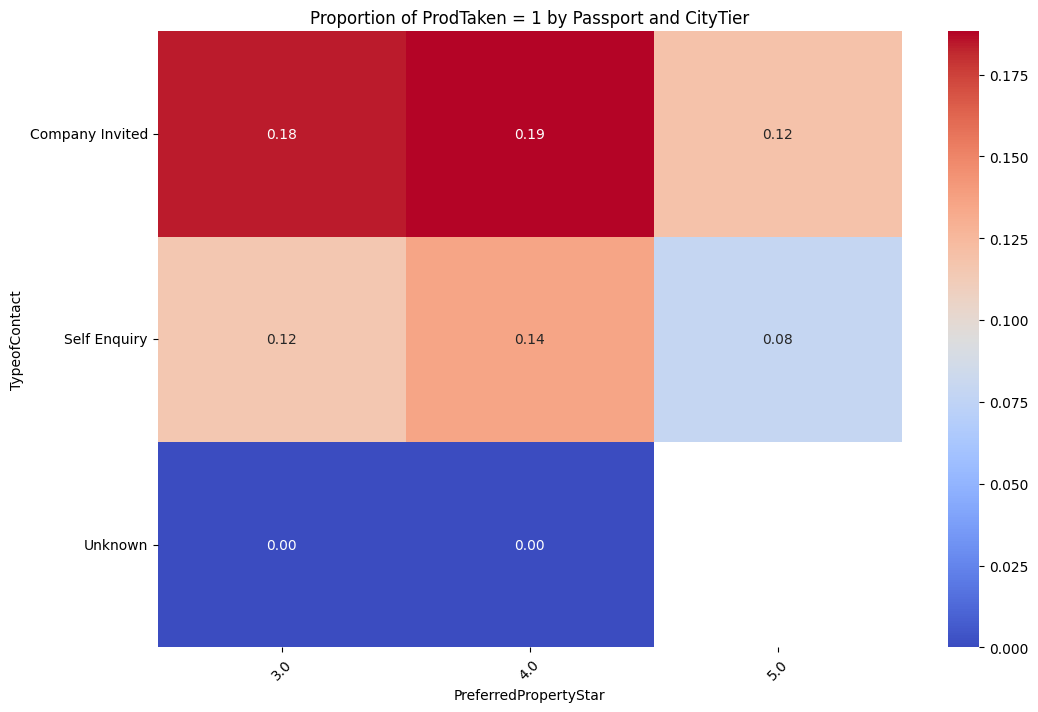

In [ ]:
# 'IncomeGroup' と 'AgeGroup' でグループ化し、 'ProdTaken' の平均を計算
grouped_data = filtered_data_non_nan.groupby(['TypeofContact', 'PreferredPropertyStar'])['ProdTaken'].mean().unstack()

# ヒートマップを描画
plt.figure(figsize=(12, 8))
sns.heatmap(grouped_data, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('Proportion of ProdTaken = 1 by Passport and CityTier')
plt.xlabel('PreferredPropertyStar')
plt.ylabel('TypeofContact')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()

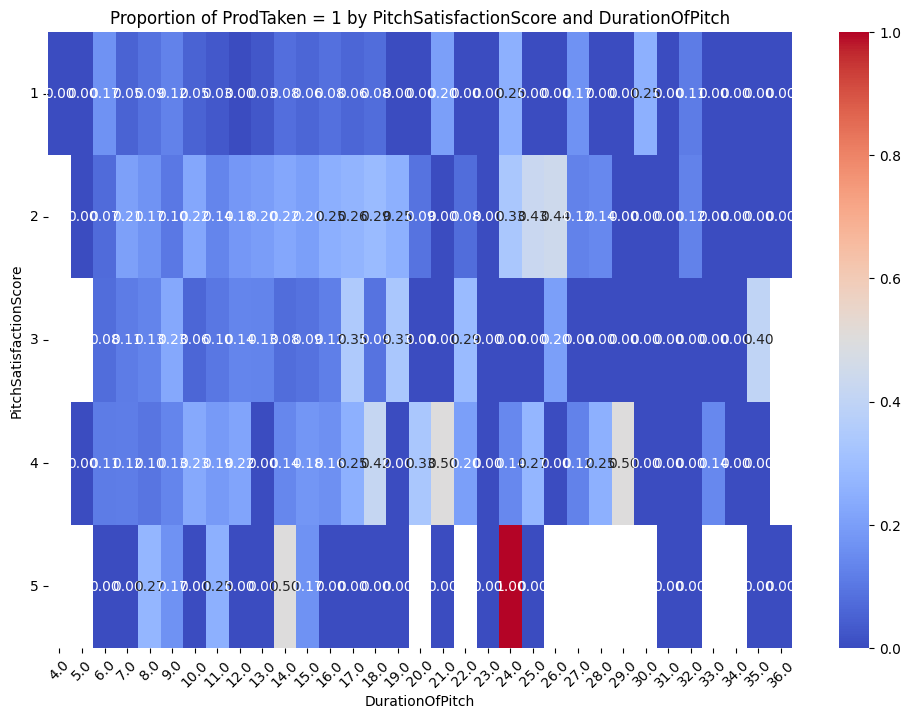

In [ ]:
# 'IncomeGroup' と 'AgeGroup' でグループ化し、 'ProdTaken' の平均を計算
grouped_data = filtered_data_non_nan.groupby(['PitchSatisfactionScore', 'DurationOfPitch'])['ProdTaken'].mean().unstack()

# ヒートマップを描画
plt.figure(figsize=(12, 8))
sns.heatmap(grouped_data, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('Proportion of ProdTaken = 1 by PitchSatisfactionScore and DurationOfPitch')
plt.xlabel('DurationOfPitch')
plt.ylabel('PitchSatisfactionScore')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()

## 特徴量エンジニアリング

In [ ]:
# Min-Maxスケーリングを使用してAgeとMonthlyIncomeを正規化
scaler = MinMaxScaler()

# Min-Maxスケーリングを使用してAgeとMonthlyIncomeを正規化
scaler = MinMaxScaler()

# AgeとMonthlyIncomeを正規化
combined_data['normalized_Age'] = scaler.fit_transform(combined_data[['Age']])
combined_data['normalized_MonthlyIncome'] = scaler.fit_transform(combined_data[['MonthlyIncome']])
# combined_data['normalized_DurationOfPitch'] = scaler.fit_transform(combined_data[['DurationOfPitch']])
# combined_data['normalized_NumberOfPersonVisiting'] = scaler.fit_transform(combined_data[['NumberOfPersonVisiting']])


# 正規化したAgeとMonthlyIncomeの積を計算して新しいカラムを追加
combined_data['age_kakeru_monthlyincome'] = combined_data['normalized_Age'] * combined_data['normalized_MonthlyIncome']

# 正規化したMonthlyIncomeとDurationOfPitchの積を計算して新しいカラムを追加
# combined_data['DurationOfPitch_kakeru_monthlyincome'] = combined_data['normalized_DurationOfPitch'] * combined_data['normalized_MonthlyIncome']

# 正規化したMonthlyIncomeとNumberOfPersonVisitingの積を計算して新しいカラムを追加
# combined_data['normalized_NumberOfPersonVisiting_kakeru_monthlyincome'] = combined_data['normalized_NumberOfPersonVisiting'] * combined_data['normalized_MonthlyIncome']

# 正規化したMonthlyIncomeとNumberOfPersonVisitingの積を計算して新しいカラムを追加
# combined_data['normalized_NumberOfPersonVisiting_kakeru_age'] = combined_data['normalized_NumberOfPersonVisiting'] * combined_data['normalized_Age']

# 結果を確認
# combined_data[['normalized_Age', 'normalized_MonthlyIncome', 'age_kakeru_monthlyincome']]

# normalized_Age と normalized_MonthlyIncome カラムを削除
drop_columns = ['normalized_Age', 'normalized_MonthlyIncome'
# ,'normalized_DurationOfPitch','normalized_NumberOfPersonVisiting'
]

combined_data = combined_data.drop(columns=drop_columns)


In [ ]:
# ターゲットエンコーディングの対象となるカテゴリカル変数とターゲット変数
category_column = 'marry_status'
target_column = 'ProdTaken'

from sklearn.model_selection import KFold


# クロスバリデーションの分割数を指定
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# エンコード後のデータを格納するデータフレーム
combined_data_encoded = combined_data.copy()

# クロスバリデーションを用いてターゲットエンコーディングを実行
for train_index, valid_index in kf.split(combined_data):
    X_tr, X_val = combined_data.iloc[train_index], combined_data.iloc[valid_index]

    # トレーニングデータでターゲットの平均を計算
    target_mean = X_tr.groupby(category_column)[target_column].mean()

    # バリデーションデータをエンコード
    combined_data_encoded.loc[valid_index, f'{category_column}_encoded'] = X_val[category_column].map(target_mean)

# クロスバリデーション終了後に、欠損値を全データの平均で補完（未知のカテゴリなど）
global_mean = combined_data[target_column].mean()
combined_data_encoded[f'{category_column}_encoded'].fillna(global_mean, inplace=True)

# エンコード結果の確認
combined_data_encoded.tail()

,id,Age,TypeofContact,CityTier,DurationOfPitch,Occupation,Gender,NumberOfPersonVisiting,NumberOfFollowups,ProductPitched,...,MonthlyIncome,ProdTaken,is_train,AgeGroup,has_car,child_num,has_child,marry_status,age_kakeru_monthlyincome,marry_status_encoded
6973,6973,41.0,Company Invited,1,14.0,Small Business,1,1.0,3.0,basic,...,261840.0,NaN,0,40.0代,0,0.0,0.0,Married,0.075655,0.103036
6974,6974,44.0,Company Invited,1,35.0,Salaried,0,3.0,5.0,deluxe,...,349770.0,NaN,0,40.0代,1,1.0,1.0,Married,0.207129,0.100448
6975,6975,24.0,Self Enquiry,2,21.0,Small Business,0,2.0,3.0,basic,...,270000.0,NaN,0,20.0代,0,0.0,0.0,Single,0.022340,0.327519
6976,6976,25.0,Self Enquiry,1,9.0,Small Business,0,2.0,3.0,basic,...,272430.0,NaN,0,20.0代,0,1.0,1.0,Married,0.026969,0.100448
6977,6977,44.0,Self Enquiry,1,NaN,Small Business,1,4.0,4.0,deluxe,...,411795.0,NaN,0,40.0代,0,3.0,1.0,Ummarried,0.292908,0.076923


In [ ]:
# ターゲットエンコーディングの対象となるカテゴリカル変数とターゲット変数
category_column = 'ProductPitched'
target_column = 'ProdTaken'

# クロスバリデーションの分割数を指定
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# エンコード後のデータを格納するデータフレーム
combined_data_encoded = combined_data_encoded.copy()

# クロスバリデーションを用いてターゲットエンコーディングを実行
for train_index, valid_index in kf.split(combined_data):
    X_tr, X_val = combined_data.iloc[train_index], combined_data.iloc[valid_index]

    # トレーニングデータでターゲットの平均を計算
    target_mean = X_tr.groupby(category_column)[target_column].mean()

    # バリデーションデータをエンコード
    combined_data_encoded.loc[valid_index, f'{category_column}_encoded'] = X_val[category_column].map(target_mean)

# クロスバリデーション終了後に、欠損値を全データの平均で補完（未知のカテゴリなど）
global_mean = combined_data[target_column].mean()
combined_data_encoded[f'{category_column}_encoded'].fillna(global_mean, inplace=True)

# エンコード結果の確認
combined_data_encoded.tail()

,id,Age,TypeofContact,CityTier,DurationOfPitch,Occupation,Gender,NumberOfPersonVisiting,NumberOfFollowups,ProductPitched,...,ProdTaken,is_train,AgeGroup,has_car,child_num,has_child,marry_status,age_kakeru_monthlyincome,marry_status_encoded,ProductPitched_encoded
6973,6973,41.0,Company Invited,1,14.0,Small Business,1,1.0,3.0,basic,...,NaN,0,40.0代,0,0.0,0.0,Married,0.075655,0.103036,0.307027
6974,6974,44.0,Company Invited,1,35.0,Salaried,0,3.0,5.0,deluxe,...,NaN,0,40.0代,1,1.0,1.0,Married,0.207129,0.100448,0.033413
6975,6975,24.0,Self Enquiry,2,21.0,Small Business,0,2.0,3.0,basic,...,NaN,0,20.0代,0,0.0,0.0,Single,0.022340,0.327519,0.297207
6976,6976,25.0,Self Enquiry,1,9.0,Small Business,0,2.0,3.0,basic,...,NaN,0,20.0代,0,1.0,1.0,Married,0.026969,0.100448,0.300000
6977,6977,44.0,Self Enquiry,1,NaN,Small Business,1,4.0,4.0,deluxe,...,NaN,0,40.0代,0,3.0,1.0,Ummarried,0.292908,0.076923,0.036047


In [ ]:
# ターゲットエンコーディングの対象となるカテゴリカル変数とターゲット変数
category_column = 'Designation'
target_column = 'ProdTaken'

# クロスバリデーションの分割数を指定
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# エンコード後のデータを格納するデータフレーム
combined_data_encoded = combined_data_encoded.copy()

# クロスバリデーションを用いてターゲットエンコーディングを実行
for train_index, valid_index in kf.split(combined_data):
    X_tr, X_val = combined_data.iloc[train_index], combined_data.iloc[valid_index]

    # トレーニングデータでターゲットの平均を計算
    target_mean = X_tr.groupby(category_column)[target_column].mean()

    # バリデーションデータをエンコード
    combined_data_encoded.loc[valid_index, f'{category_column}_encoded'] = X_val[category_column].map(target_mean)

# クロスバリデーション終了後に、欠損値を全データの平均で補完（未知のカテゴリなど）
global_mean = combined_data[target_column].mean()
combined_data_encoded[f'{category_column}_encoded'].fillna(global_mean, inplace=True)

# エンコード結果の確認
combined_data_encoded.tail()

,id,Age,TypeofContact,CityTier,DurationOfPitch,Occupation,Gender,NumberOfPersonVisiting,NumberOfFollowups,ProductPitched,...,is_train,AgeGroup,has_car,child_num,has_child,marry_status,age_kakeru_monthlyincome,marry_status_encoded,ProductPitched_encoded,Designation_encoded
6973,6973,41.0,Company Invited,1,14.0,Small Business,1,1.0,3.0,basic,...,0,40.0代,0,0.0,0.0,Married,0.075655,0.103036,0.307027,0.310195
6974,6974,44.0,Company Invited,1,35.0,Salaried,0,3.0,5.0,deluxe,...,0,40.0代,1,1.0,1.0,Married,0.207129,0.100448,0.033413,0.036514
6975,6975,24.0,Self Enquiry,2,21.0,Small Business,0,2.0,3.0,basic,...,0,20.0代,0,0.0,0.0,Single,0.022340,0.327519,0.297207,0.301232
6976,6976,25.0,Self Enquiry,1,9.0,Small Business,0,2.0,3.0,basic,...,0,20.0代,0,1.0,1.0,Married,0.026969,0.100448,0.300000,0.305705
6977,6977,44.0,Self Enquiry,1,NaN,Small Business,1,4.0,4.0,deluxe,...,0,40.0代,0,3.0,1.0,Ummarried,0.292908,0.076923,0.036047,0.037931


In [ ]:
# 正規化したAgeとMonthlyIncomeの積を計算して新しいカラムを追加
# combined_data_encoded['ProductPitched_kakeru_Designation'] = combined_data_encoded['ProductPitched_encoded'] * combined_data_encoded['Designation_encoded']
# combined_data_encoded['ProductPitched_kakeru_marry_status'] = combined_data_encoded['ProductPitched_encoded'] * combined_data_encoded['marry_status_encoded']
# combined_data_encoded['Designation_kakeru_marry_status'] = combined_data_encoded['Designation_encoded'] * combined_data_encoded['marry_status_encoded']

# normalized_Age と normalized_MonthlyIncome カラムを削除
drop_columns = ['marry_status_encoded', 'ProductPitched_encoded','Designation_encoded']

combined_data_encoded = combined_data_encoded.drop(columns=drop_columns)

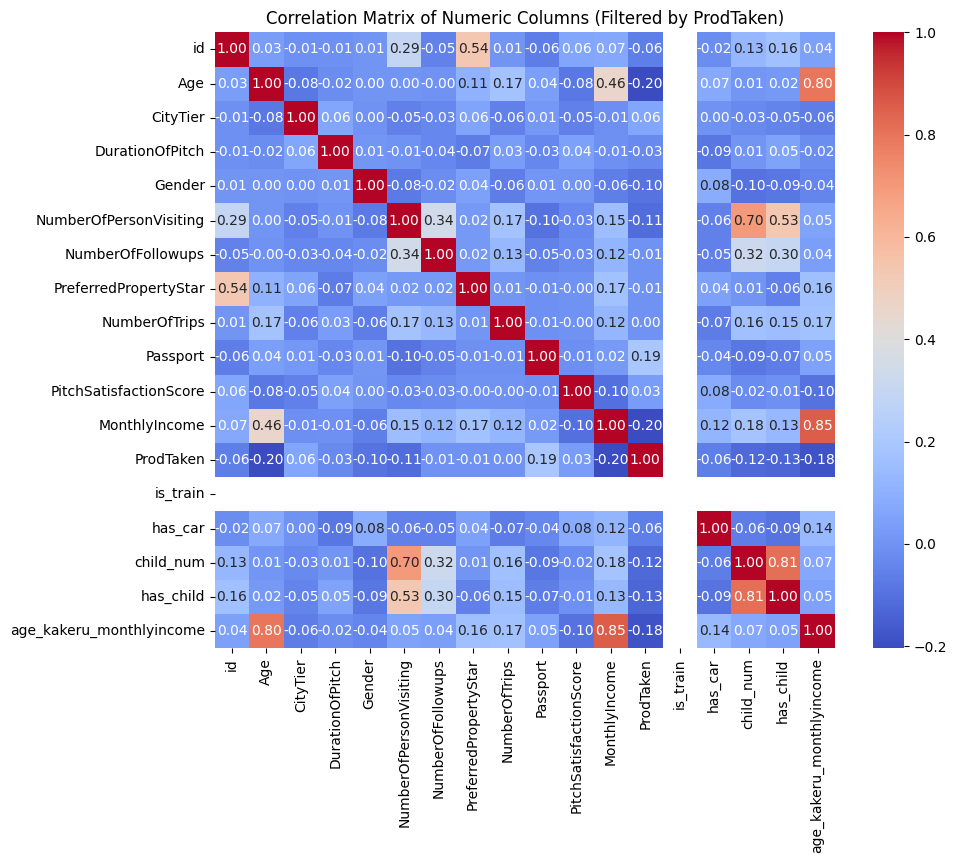

In [ ]:
# 'ProdTaken' が null ではないものに絞り込む
filtered_data = combined_data_encoded[combined_data_encoded['ProdTaken'].notnull()]

# 数値型のカラムに絞って相関行列を計算
numeric_cols = filtered_data.select_dtypes(include=['number']).columns
corr_matrix = filtered_data[numeric_cols].corr()

# 相関行列をヒートマップで表示
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Numeric Columns (Filtered by ProdTaken)')
plt.show()

## 欠損値の補完


In [ ]:
# # 'Age' と 'MonthlyIncome' が -1 のものを NaN に置換
# combined_data_encoded['Age'] = combined_data_encoded['Age'].replace(-1, np.nan)
# # combined_data_encoded['MonthlyIncome'] = combined_data_encoded['MonthlyIncome'].replace(-1, np.nan)

# # 確認のための出力
# # print(combined_data_encoded.isnull().sum())

In [ ]:
# # 欠損値のある列を特定（例: 'target_column'に欠損値があると仮定）
# target_column = 'Age'

# # 'ProdTaken'カラムを除外して特徴量を選択
# X = combined_data_encoded.drop(columns=[target_column, 'ProdTaken','id','is_train'])
# y = combined_data_encoded[target_column]

# # 欠損値のないデータを使ってランダムフォレストモデルを訓練
# X_train = X[~y.isna()]
# y_train = y[~y.isna()]

# # 欠損値があるデータを特定
# X_missing = X[y.isna()]

# # ランダムフォレストモデルの定義と訓練
# rf = RandomForestRegressor(n_estimators=100, random_state=42)
# rf.fit(X_train, y_train)

# # 欠損値の予測
# y_pred = rf.predict(X_missing)

# # 欠損値の補完
# combined_data_encoded.loc[y.isna(), target_column] = y_pred

# # 補完後のデータを表示
# # print(combined_data_encoded.isnull().sum())

In [ ]:
# # 'Age' と 'MonthlyIncome' が -1 のものを NaN に置換
# # combined_data_encoded['Age'] = combined_data_encoded['Age'].replace(-1, np.nan)
# combined_data_encoded['MonthlyIncome'] = combined_data_encoded['MonthlyIncome'].replace(-1, np.nan)

# # 確認のための出力
# # print(combined_data_encoded.isnull().sum())

In [ ]:
# # 欠損値のある列を特定（例: 'target_column'に欠損値があると仮定）
# target_column = 'MonthlyIncome'

# # 'ProdTaken'カラムを除外して特徴量を選択
# X = combined_data_encoded.drop(columns=[target_column, 'ProdTaken','id','is_train'])
# y = combined_data_encoded[target_column]

# # 欠損値のないデータを使ってランダムフォレストモデルを訓練
# X_train = X[~y.isna()]
# y_train = y[~y.isna()]

# # 欠損値があるデータを特定
# X_missing = X[y.isna()]

# # ランダムフォレストモデルの定義と訓練
# rf = RandomForestRegressor(n_estimators=100, random_state=42)
# rf.fit(X_train, y_train)

# # 欠損値の予測
# y_pred = rf.predict(X_missing)

# # 欠損値の補完
# combined_data_encoded.loc[y.isna(), target_column] = y_pred

# # 補完後のデータを表示
# # print(combined_data_encoded.isnull().sum())

In [ ]:
# combined_data_encoded['DurationOfPitch'] = combined_data_encoded['DurationOfPitch'].replace(-1, np.nan)

# # 確認のための出力
# # print(combined_data_encoded.isnull().sum())

In [ ]:
# # 欠損値のある列を特定（例: 'target_column'に欠損値があると仮定）
# target_column = 'DurationOfPitch'

# # 'ProdTaken'カラムを除外して特徴量を選択
# X = combined_data_encoded.drop(columns=[target_column, 'ProdTaken','id','is_train'])
# y = combined_data_encoded[target_column]

# # 欠損値のないデータを使ってランダムフォレストモデルを訓練
# X_train = X[~y.isna()]
# y_train = y[~y.isna()]

# # 欠損値があるデータを特定
# X_missing = X[y.isna()]

# # ランダムフォレストモデルの定義と訓練
# rf = RandomForestRegressor(n_estimators=100, random_state=42)
# rf.fit(X_train, y_train)

# # 欠損値の予測
# y_pred = rf.predict(X_missing)

# # 欠損値の補完
# combined_data_encoded.loc[y.isna(), target_column] = y_pred

# # 補完後のデータを表示
# # print(combined_data_encoded.isnull().sum())

In [ ]:
# combined_data_encoded = combined_data_encoded.astype(float)

## エンコーディング

In [ ]:
# # One-Hotエンコーディングを実施
# combined_data_encoded = pd.get_dummies(combined_data, columns=categorical_cols, drop_first=False)

# combined_data_encoded.head()

In [ ]:
combined_data = combined_data_encoded

In [ ]:
categorical_cols = ['TypeofContact',
 'Occupation',
 'Designation',
 'ProductPitched',
 'marry_status',
 'CityTier',]

In [ ]:
# categorical_colsに該当する列のデータ型をstring型に変更
combined_data[categorical_cols] = combined_data[categorical_cols].astype(str)

In [ ]:
combined_data.dtypes

,0
id,int64
Age,float64
TypeofContact,object
CityTier,object
DurationOfPitch,float64
Occupation,object
Gender,int64
NumberOfPersonVisiting,float64
NumberOfFollowups,float64
ProductPitched,object


In [ ]:
# categorical_cols = ['TypeofContact',
#  'Occupation',
# #  'Designation',
# #  'ProductPitched',
#  'marry_status',
#  'CityTier',
#  'PreferredPropertyStar',
#  'PitchSatisfactionScore']

In [ ]:
combined_data.dtypes

,0
id,int64
Age,float64
TypeofContact,object
CityTier,object
DurationOfPitch,float64
Occupation,object
Gender,int64
NumberOfPersonVisiting,float64
NumberOfFollowups,float64
ProductPitched,object


In [ ]:
combined_data.isnull().sum()

,0
id,0
Age,193
TypeofContact,0
CityTier,0
DurationOfPitch,1939
Occupation,0
Gender,0
NumberOfPersonVisiting,0
NumberOfFollowups,57
ProductPitched,0


# 4.3 データセットを訓練データセットとテストデータセットに分割する

In [ ]:
# combined_data_encodedをtrainとtestのでーたセットに戻す

train = combined_data[combined_data['is_train'] == 1]
test = combined_data[combined_data['is_train'] == 0]

# "ProdTaken"は予測対象とするため、別途target変数に格納する
target = train["ProdTaken"]

# 削除するカラムをリストとして定義
columns_to_drop = ['is_train', 'ProdTaken', 'id','AgeGroup']

# trainデータセットからカラムを削除
train.drop(columns=columns_to_drop, axis=1, inplace=True)

# testデータセットからカラムを削除
test.drop(columns=columns_to_drop, axis=1, inplace=True)

<ipython-input-445-7829d976c525>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train.drop(columns=columns_to_drop, axis=1, inplace=True)
<ipython-input-445-7829d976c525>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.drop(columns=columns_to_drop, axis=1, inplace=True)


In [ ]:
train.shape

(3489, 20)

In [ ]:
test.shape

(3489, 20)

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(
        train, target, test_size=0.3, random_state=42, stratify=target
)
print(X_train.shape, X_valid.shape, y_train.shape
, y_valid.shape)

(2442, 20) (1047, 20) (2442,) (1047,)


## 5. 学習と検証

Fitting 5 folds for each of 32 candidates, totalling 160 fits
Best parameters: {'border_count': 64, 'depth': 3, 'iterations': 200, 'l2_leaf_reg': 3, 'learning_rate': 0.05}
Best cross-validation AUC: 0.8332811631841686
ROC AUC after tuning: 0.8467436959088803


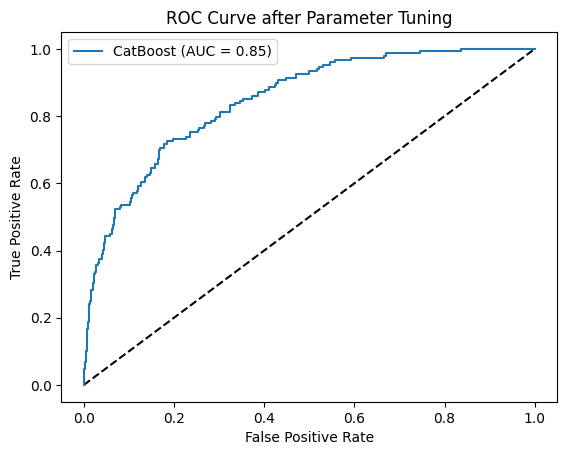

In [ ]:
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostClassifier
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

kf = 5  # クロスバリデーションの分割数

param_grid = {
    'iterations': [100, 200],  # 少ないデータでは過学習を防ぐために、比較的少ない反復回数を選択
    'learning_rate': [0.05, 0.1],  # 一般的な値を絞って選択
    'depth': [3, 5],  # より浅い木を選択して過学習を防ぐ
    'l2_leaf_reg': [3, 5],  # 一般的な範囲に絞る
    'border_count': [64, 128],  # 高速なトレーニングを目指して選択肢を絞る
}


# CatBoostのインスタンスを作成
catboost_model = CatBoostClassifier(random_seed=42, verbose=0, early_stopping_rounds=10)

# カテゴリカル変数を指定（インデックスまたはカラム名で指定可能）
cat_features =  categorical_cols # 例として 'CategoryFeature1', 'CategoryFeature2'

# GridSearchCVの設定
grid_search = GridSearchCV(
    estimator=catboost_model,
    param_grid=param_grid,
    cv=kf,  # クロスバリデーションの分割数
    scoring='roc_auc',
    n_jobs=-1,  # 並列処理の設定
    verbose=1  # 詳細な出力を有効にする
)

# GridSearchCVの実行（パラメータチューニング）
grid_search.fit(X_train, y_train, cat_features=cat_features)  # cat_features を明示的に指定

# 最適なパラメータとスコアの取得
best_params = grid_search.best_params_
best_score = grid_search.best_score_
print(f"Best parameters: {best_params}")
print(f"Best cross-validation AUC: {best_score}")

# 最適なパラメータを使用してモデルを再トレーニング
best_catboost_model = grid_search.best_estimator_

# y_validに対する予測確率を計算
pred_proba = best_catboost_model.predict_proba(X_valid)

# ROC曲線を計算
fpr, tpr, thresholds = roc_curve(y_valid, pred_proba[:, 1])

# ROC AUCスコアの計算
roc_auc = roc_auc_score(y_valid, pred_proba[:, 1])
print(f"ROC AUC after tuning: {roc_auc}")

# ROC曲線のプロット
plt.plot([0, 1], [0, 1], 'k--')  # 斜めの基準線
plt.plot(fpr, tpr, label=f'CatBoost (AUC = {roc_auc:.2f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve after Parameter Tuning')
plt.legend(loc='best')
plt.show()


ProductPitched: 23.044622206845553
age_kakeru_monthlyincome: 11.801569130685458
Passport: 8.057975505774715
marry_status: 7.270773536110053
CityTier: 7.034356174071328
MonthlyIncome: 7.010312866958689
Designation: 5.535531199966766
Gender: 5.3695772322782265
Age: 4.549892175411582
NumberOfTrips: 3.486780732168029
NumberOfPersonVisiting: 2.619748017159095
PitchSatisfactionScore: 2.33758762586843
PreferredPropertyStar: 1.9874655953698181
DurationOfPitch: 1.7858120040303997
child_num: 1.6370062934501373
TypeofContact: 1.634400389458521
Occupation: 1.411386818938429
NumberOfFollowups: 1.3575608358621454
has_child: 1.060723093081316
has_car: 1.006918566511334


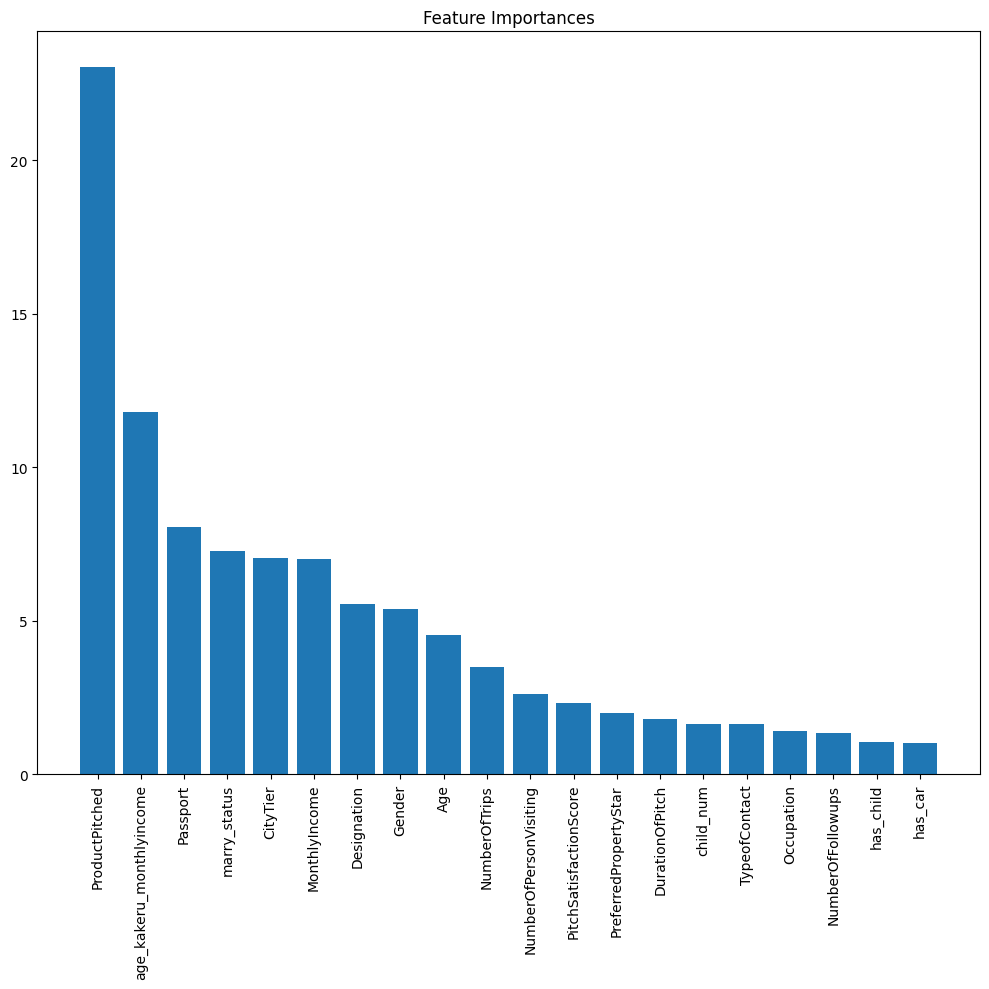

In [ ]:
# 特徴量の重要度を抽出する
importances = best_catboost_model.feature_importances_

# 重要度の降順で特徴量のインデックスを抽出
indices = np.argsort(importances)[::-1]

# 重要度の降順で特徴量の名称、重要度を表示
for i in range(X_train.shape[1]):
    print(f"{X_train.columns[indices[i]]}: {importances[indices[i]]}")

# 表示する
plt.figure(figsize=(10, 10))
plt.title('Feature Importances')
plt.bar(range(X_train.shape[1]), importances[indices], align='center')
plt.xticks(range(X_train.shape[1]), X_train.columns[indices], rotation=90)
plt.tight_layout()
plt.show()

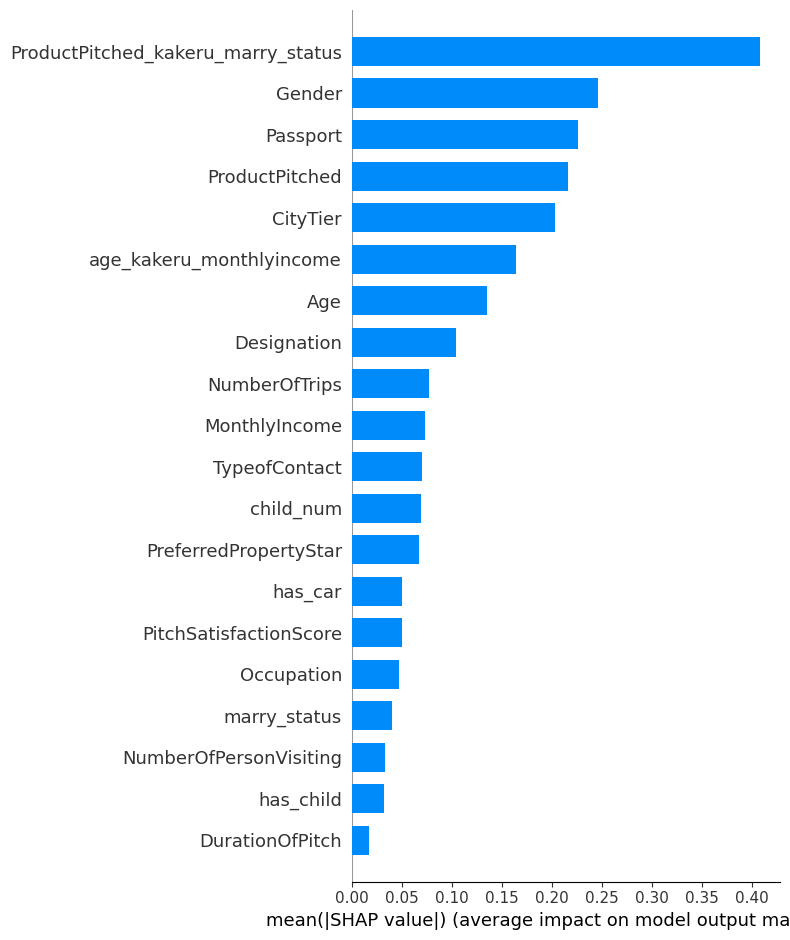

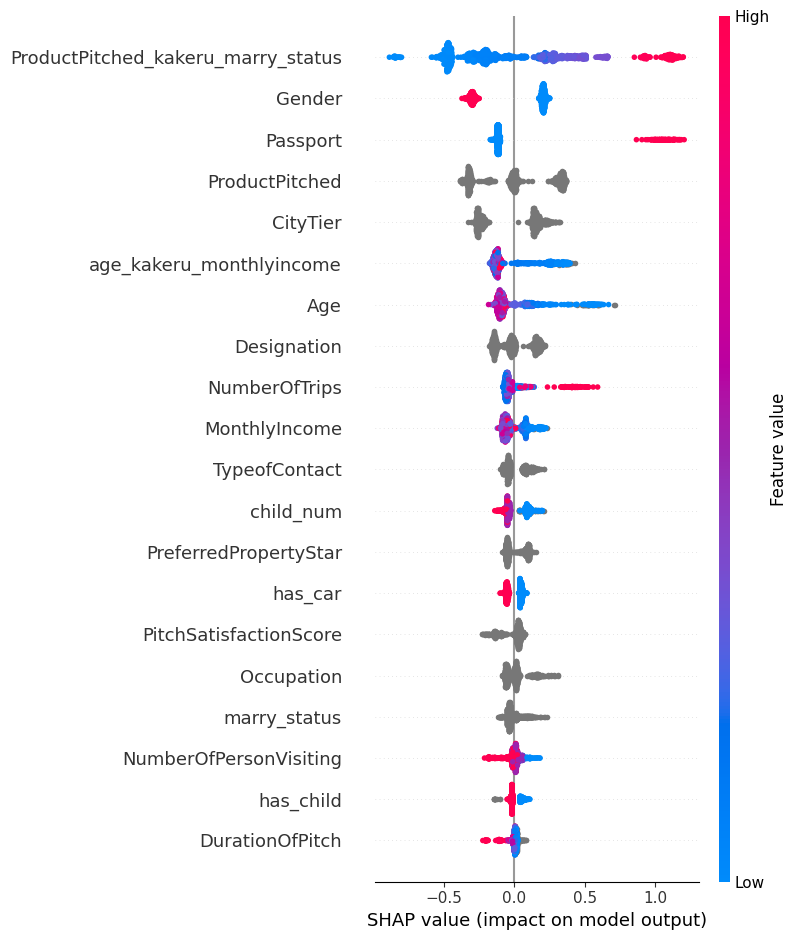

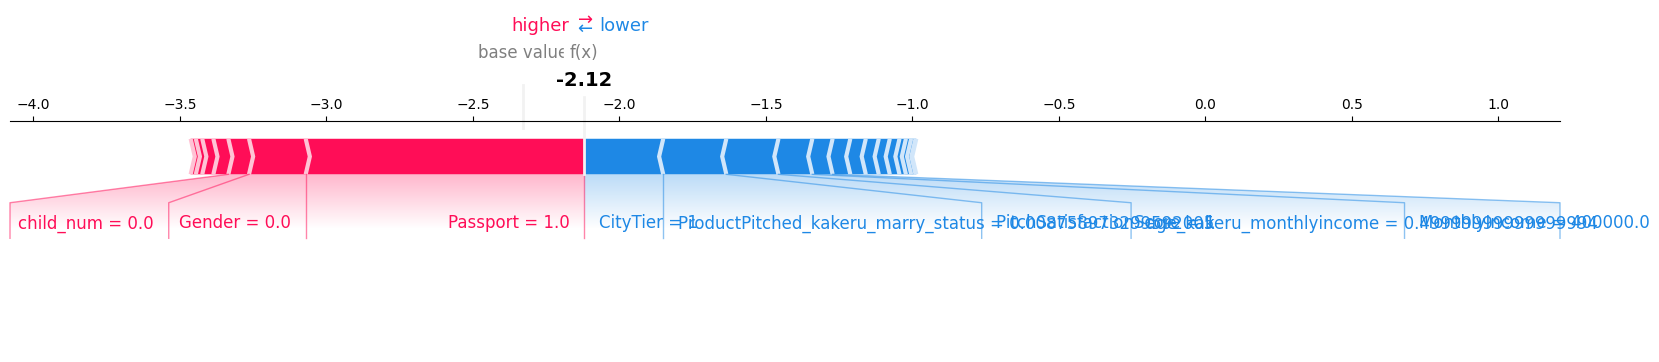

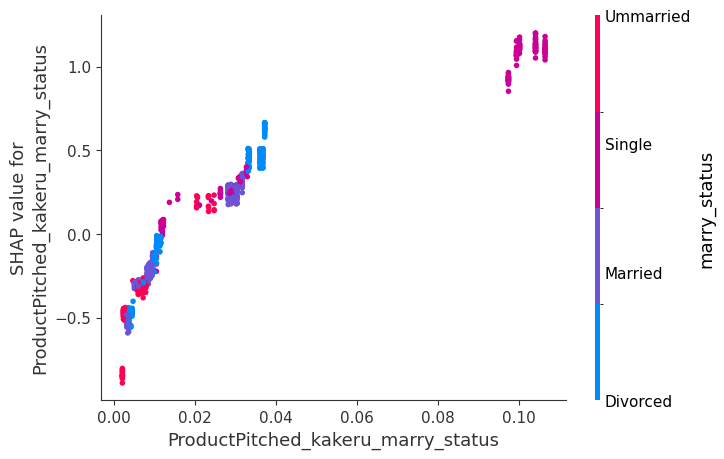

In [ ]:

# SHAPのexplainerを作成
explainer = shap.TreeExplainer(best_catboost_model)

# 検証データに対するSHAP値を計算
shap_values = explainer.shap_values(X_valid)

# 各特徴量の寄与度を可視化するsummary plot
shap.summary_plot(shap_values, X_valid, plot_type="bar")

# 各特徴量の影響方向を可視化するsummary plot（影響方向込み）
shap.summary_plot(shap_values, X_valid)

# 特定のデータポイントに対するSHAPのforce plotを表示
# ここでは、検証データの最初のサンプルを例にとります
shap.force_plot(explainer.expected_value, shap_values[0,:], X_valid.iloc[0,:], matplotlib=True)

# 特定のデータポイントに対するSHAPのdependence plotを表示
# ここでは、最も重要な特徴量を選んで可視化します
shap.dependence_plot(np.argmax(np.abs(shap_values).mean(0)), shap_values, X_valid)


# 5. 学習と検証


In [ ]:
# # ランダムフォレストモデルのインスタンスを作成
# rf = RandomForestClassifier(random_state=42)

# # パラメータのグリッドを定義
# param_grid = {
#     'n_estimators': [100, 200, 300],
#     'max_depth': [10, 20, 30],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4],
#     'max_features': ['auto', 'sqrt', 'log2']
# }

# # グリッドサーチを設定（3分割のクロスバリデーションを使用）
# grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)

# # トレーニングデータに対してフィッティング
# grid_search.fit(X_train, y_train)

# # 最適なパラメータを表示
# print("Best parameters found: ", grid_search.best_params_)

# # 最適なモデルを使ってテストデータを予測
# best_rf = grid_search.best_estimator_
# y_pred = best_rf.predict(X_valid)

# # テストデータに対する精度を表示
# print("Test Accuracy: ", accuracy_score(y_valid, y_pred))


In [ ]:
# # ランダムフォレストモデルを呼び出します。ランダムフォレストは実行するたびに学習結果が変わることがあるのでrandom_stateに数字を指定して結果を固定します。
# model = RandomForestClassifier(random_state=42)
# # model.fit() で学習します。訓練データと訓練データの目的変数を指定します。
# model.fit(X_train, y_train)

In [ ]:
# # predict_proba() で予測します。予測したいデータを入力します。
# pred = best_rf.predict_proba(X_valid)

In [ ]:
# # 予測の中身を確認します
# print(pred[:5])

In [ ]:
# y_valid[:5]

In [ ]:
# # AUCの評価はroc_auc_score(正解データ, 予測データ)で可能です。
# # 成約したかどうかを判定するため、2列目の1の確率(成約している確率)を予測データとして入力します。
# score = roc_auc_score(y_valid, pred[:, 1])
# print(score)

NameError: name 'pred' is not defined

In [ ]:
# from sklearn.metrics import roc_curve
# fpr, tpr, thresholds = roc_curve(y_valid, pred[:, 1])

# plt.plot([0, 1], [0, 1], 'k--')
# plt.plot(fpr,tpr,label='LogisticRegression')
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('ROC Curve')
# plt.show()

NameError: name 'pred' is not defined

## 特徴量の重要度を可視化する

In [ ]:
# # 特徴量の重要度を抽出する
# importances = best_rf.feature_importances_

# # 重要度の降順で特徴量のインデックスを抽出
# indices = np.argsort(importances)[::-1]

# # 重要度の降順で特徴量の名称、重要度を表示
# for i in range(X_train.shape[1]):
#     print(f"{X_train.columns[indices[i]]}: {importances[indices[i]]}")

# # 表示する
# plt.figure(figsize=(10, 10))
# plt.title('Feature Importances')
# plt.bar(range(X_train.shape[1]), importances[indices], align='center')
# plt.xticks(range(X_train.shape[1]), X_train.columns[indices], rotation=90)
# plt.tight_layout()
# plt.show()

In [ ]:
# print(X_valid.dtypes)

In [ ]:
# print(X_valid.dtypes)

In [ ]:
# X_valid = X_valid.astype(float)


In [ ]:
# # explainerの作成
# explainer = shap.TreeExplainer(
#       model=best_rf
#       ,data=X_valid)

# # SHAP値の計算
# shap_values = explainer.shap_values(X_valid)

In [ ]:
# shap.plots.bar(shap_values=shap_values)

In [ ]:
# # SHAP summary plot
# shap.plots.beeswarm(shap_values, max_display=10)

## lightGBMモデルの作成

In [ ]:
# # LightGBMのインスタンスを作成
# lgb_model = lgb.LGBMClassifier(random_state=42)

# # パラメータのグリッドを定義
# param_grid = {
#     'n_estimators': [100, 200, 300],
#     'max_depth': [10, 20, 30],
#     'num_leaves': [31, 50, 70],
#     'min_child_samples': [20, 50, 100],
#     'learning_rate': [0.01, 0.05, 0.1],
#     'colsample_bytree': [0.8, 0.9, 1.0]
# }

# # グリッドサーチを設定（3分割のクロスバリデーションを使用）
# grid_search = GridSearchCV(estimator=lgb_model, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)

# # トレーニングデータに対してフィッティング
# grid_search.fit(X_train, y_train)

# # 最適なパラメータを表示
# print("Best parameters found: ", grid_search.best_params_)

# # 最適なモデルを使ってテストデータを予測
# best_lgb = grid_search.best_estimator_
# y_pred = best_lgb.predict(X_valid)

# # テストデータに対する精度を表示
# print("Test Accuracy: ", accuracy_score(y_valid, y_pred))


In [ ]:
# # predict_proba() で予測します。予測したいデータを入力します。
# pred = best_lgb.predict_proba(X_valid)

NameError: name 'best_lgb' is not defined

In [ ]:
# # AUCの評価はroc_auc_score(正解データ, 予測データ)で可能です。
# # 成約したかどうかを判定するため、2列目の1の確率(成約している確率)を予測データとして入力します。
# score = roc_auc_score(y_valid, pred[:, 1])
# print(score)

NameError: name 'pred' is not defined

In [ ]:
# fpr, tpr, thresholds = roc_curve(y_valid, pred[:, 1])

# plt.plot([0, 1], [0, 1], 'k--')
# plt.plot(fpr,tpr,label='LogisticRegression')
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('ROC Curve')
# plt.show()

# 6 提出

In [ ]:
# テストデータを用いて予測します。
predict = best_catboost_model.predict_proba(test)

In [ ]:
# submit_sample.csvを読み込みます。
submit = pd.read_csv("/content/drive/MyDrive/SIGNATE_Cup 2024/data/sample_submit.csv", header=None)
submit.head()

,0,1
0,3489,0.119451
1,3490,0.343575
2,3491,0.119451
3,3492,0.119451
4,3493,0.119451


In [ ]:
# 提出ファイルの2列目を予測値で置き換えます。
submit[1] = predict[:, 1]

In [ ]:
#確認してみましょう
submit.head()

,0,1
0,3489,0.093678
1,3490,0.180336
2,3491,0.249414
3,3492,0.526800
4,3493,0.402337


In [ ]:
#submission.csvでデータを保存(提出様式はindex=False, header=Noneとしてください。)
submit.to_csv("submission.csv", index=False, header=None)

In [ ]:
# ディレクトリを指定して保存
file_path = '/content/drive/MyDrive/SIGNATE_Cup 2024/data/submission_20240814_no_proceed_0818_2.csv'
submit.to_csv(file_path, index=False, header=None)

print(f'File saved to {file_path}')

File saved to /content/drive/MyDrive/SIGNATE_Cup 2024/data/submission_20240814_no_proceed_0818_2.csv
